## Multi-class classification machine(Poverty Level Predicton)
### Core Data fields
 - id : 일변번호
 - Target : 수입 수준
  - 극도로 빈곤
  - 빈곤
  - 취약 계층
  - 비취약 계층
 - idhogar : 가정의 고유식별 번호
 - parentesco1 : 세대주 여부
## 목표 : 각 개인의 특징을 고려하여 가정 빈곤 수준 예측
## 평가방법 
 - 이진분류 F1 score
  - F1 score = 2*(precision*recall) / (precision+recall)
 - 다중분류 F1 score
  - F1 score = (F1 Class 1 + F1 Class 2 + F1 Class 3 + F1 Class 4) / 4
  

## 목차 
### 1. 문제 이해

### 2. EDA
 - data 문제 확인
 - 결측값 처리
 
### 3.Feature Engineering
 - 집합 data
 - feature 선택 

### 4.모델링
 - 여러가지 모델링 시도
 - 변수 선택

### 5. 모델 최적화
 - 최적 모델링 조정

### 6. 최적 모델링

### 7. 예측 결과 
    

https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough/data

In [1]:
## 데이터 핸들링 라이브러리 
import pandas as pd
import numpy as np

## 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

## 시각화 고정
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

##
from collections import OrderedDict


In [2]:
train = pd.read_csv('C:/Users/USER/Desktop/kaggle/costa-rican-household-poverty-prediction/train.csv')
test = pd.read_csv('C:/Users/USER/Desktop/kaggle/costa-rican-household-poverty-prediction/test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


Text(0.5, 1.0, 'Count of Unique Values in Integer Columns')

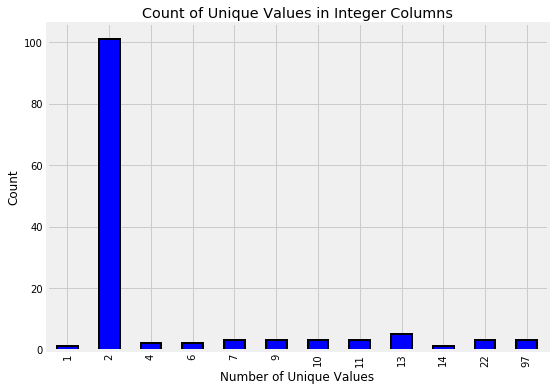

In [5]:
## 이산형 변수 속성 확인
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'blue',figsize = (8,6), edgecolor ='k',linewidth =2)
plt.xlabel('Number of Unique Values')
plt.ylabel('Count')
plt.title('Count of Unique Values in Integer Columns')


 - 이산형 변수 중 이진 형태(0,1)의 속성이 가장 많음

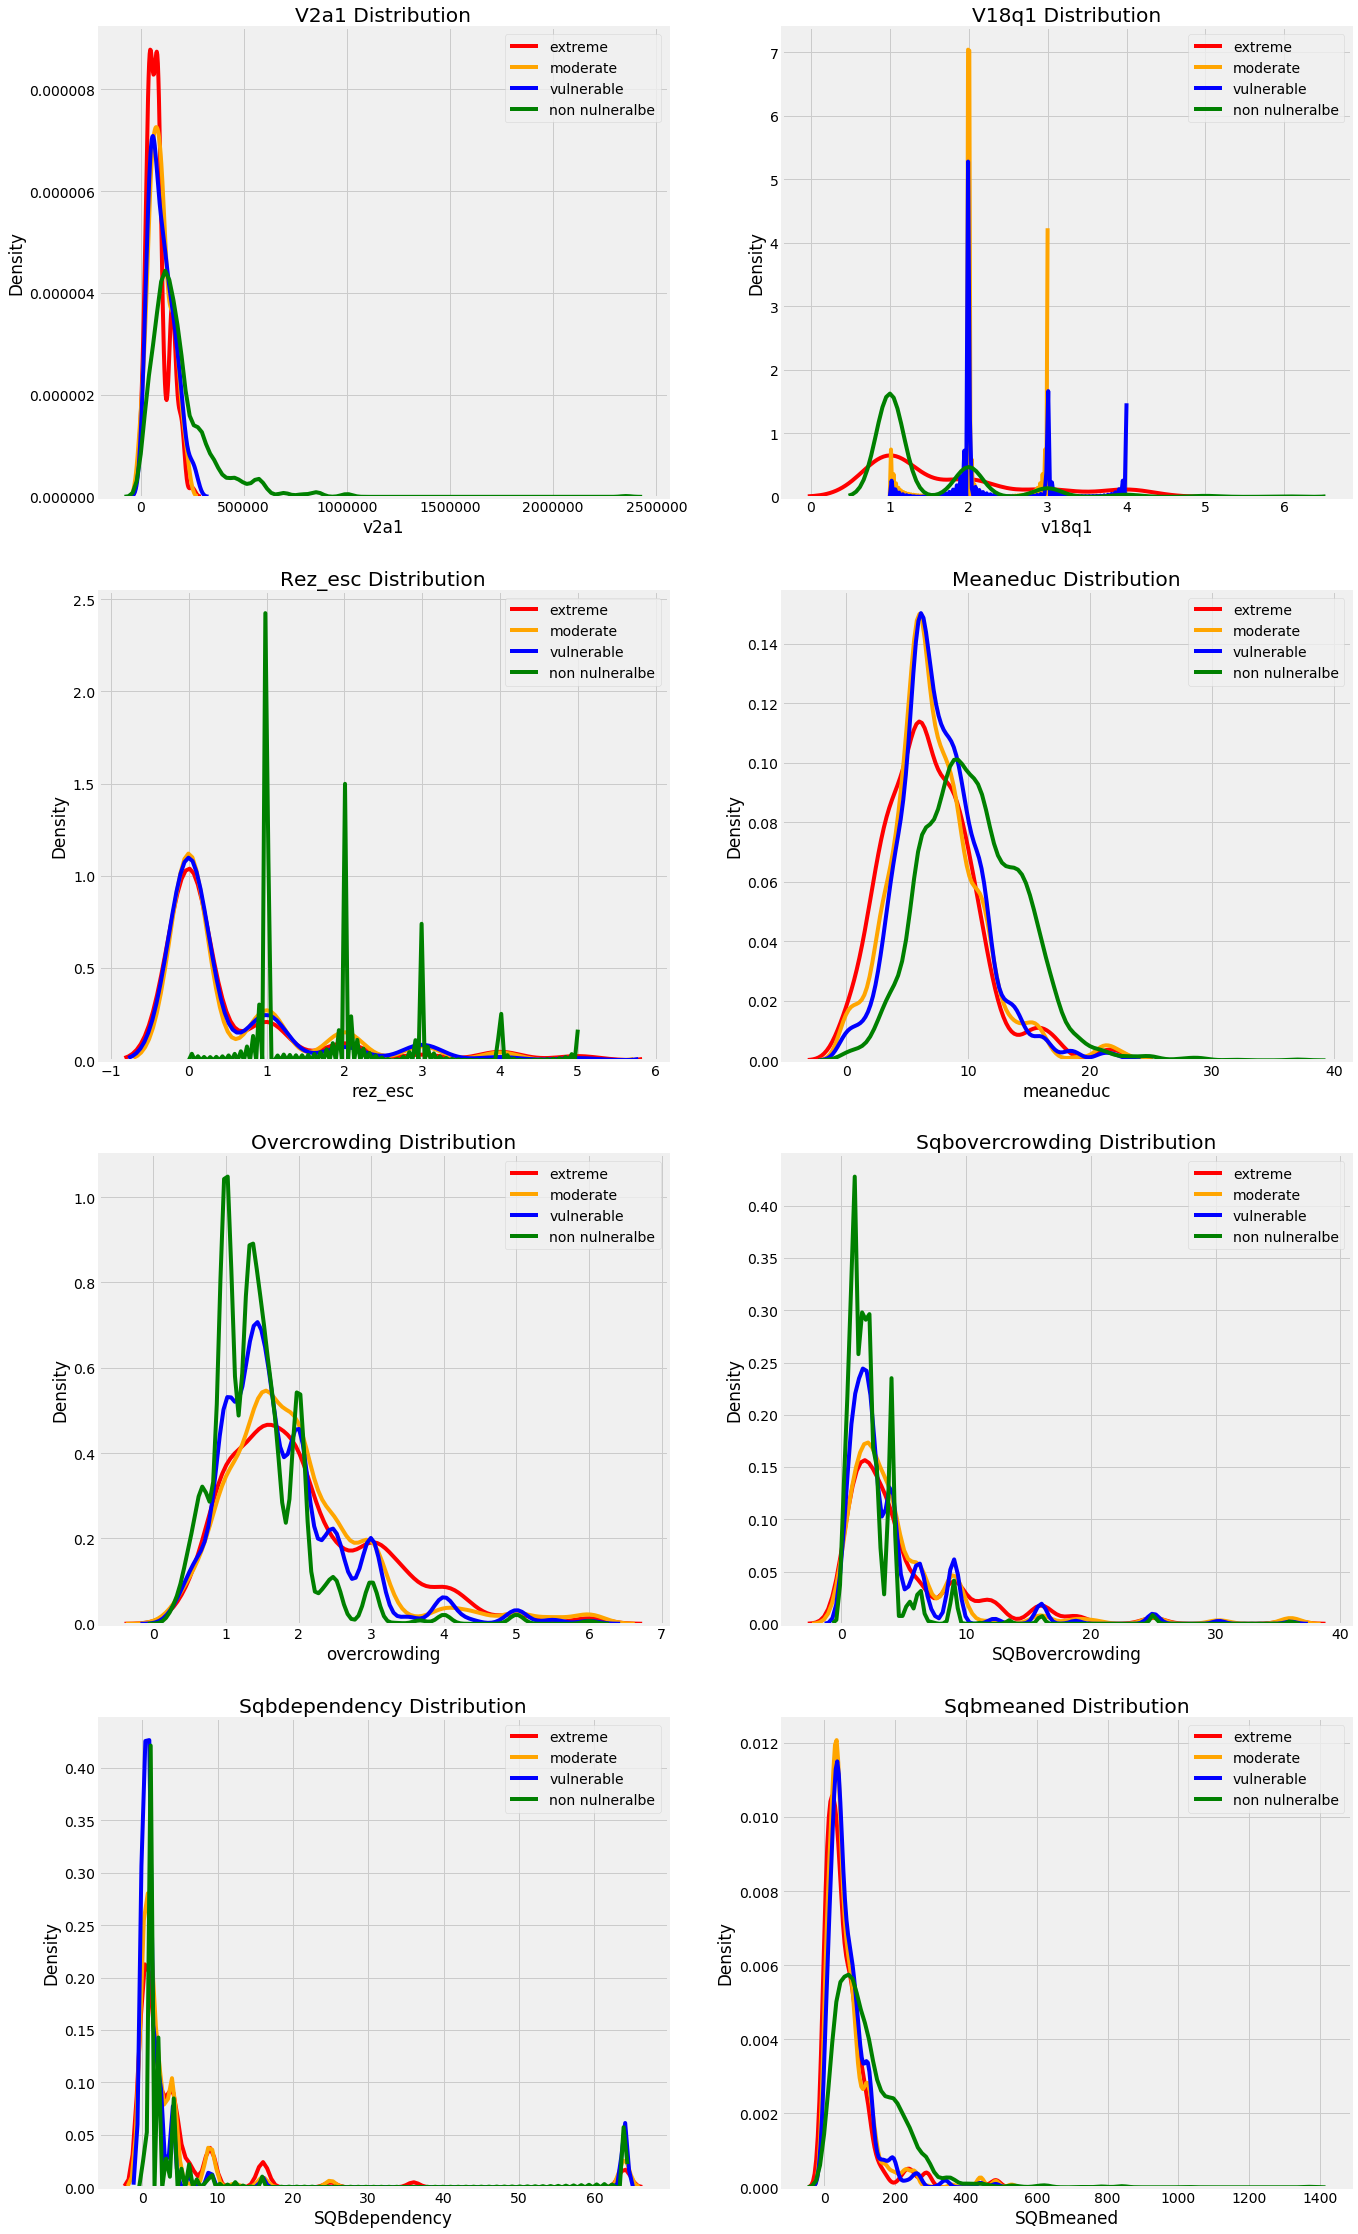

In [6]:
## OrderdDict를 사용하여 빈곤수준(Target)에 대한 색상 부여
from collections import OrderedDict
plt.figure(figsize =(20,16))
plt.style.use('fivethirtyeight')

## 색상 부여
colors = OrderedDict({1: 'red',2:'orange',3:'blue',4:'green'})
poverty_mapping =OrderedDict({1: 'extreme', 2:'moderate',3:'vulnerable',4:'non nulneralbe'})


## 연속형 변수만 반복
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i+1)
    
    # 타켓변수 반복
    for poverty_level, color in colors.items():  # .items 키와 값 리턴
        # 각 빈곤 수준으로 라인 구분
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(),
                   ax = ax, color = color, label = poverty_mapping[poverty_level])
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Density')
plt.subplots_adjust(top = 2)
                

 - 성인의 평균 교육 수준이 빈곤 수준과 관련이있는 것으로 보이며 평균 성인 교육 수준이 높을수록 빈곤 수준이 낮은 대상의 값이 높임

In [7]:
## 명목형 변수
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


 - dependency : (19 세 이하 또는 64 세 이상 가구 구성원 수) / (19-64 세 가구 구성원 수)
 - edjefe : 세대주의 교육 수준(남성)
 - dejefa : 세대주의 교육 수준(여성)        

In [8]:
## 변수속셩 변경
mapping = {'yes':1,'no':0}

## train / test set 적용
for df in [train, test]:
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float)
    df['edjefa'] =df['edjefa'].replace(mapping).astype(np.float)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float)

    

In [9]:
train[['dependency','edjefa','edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


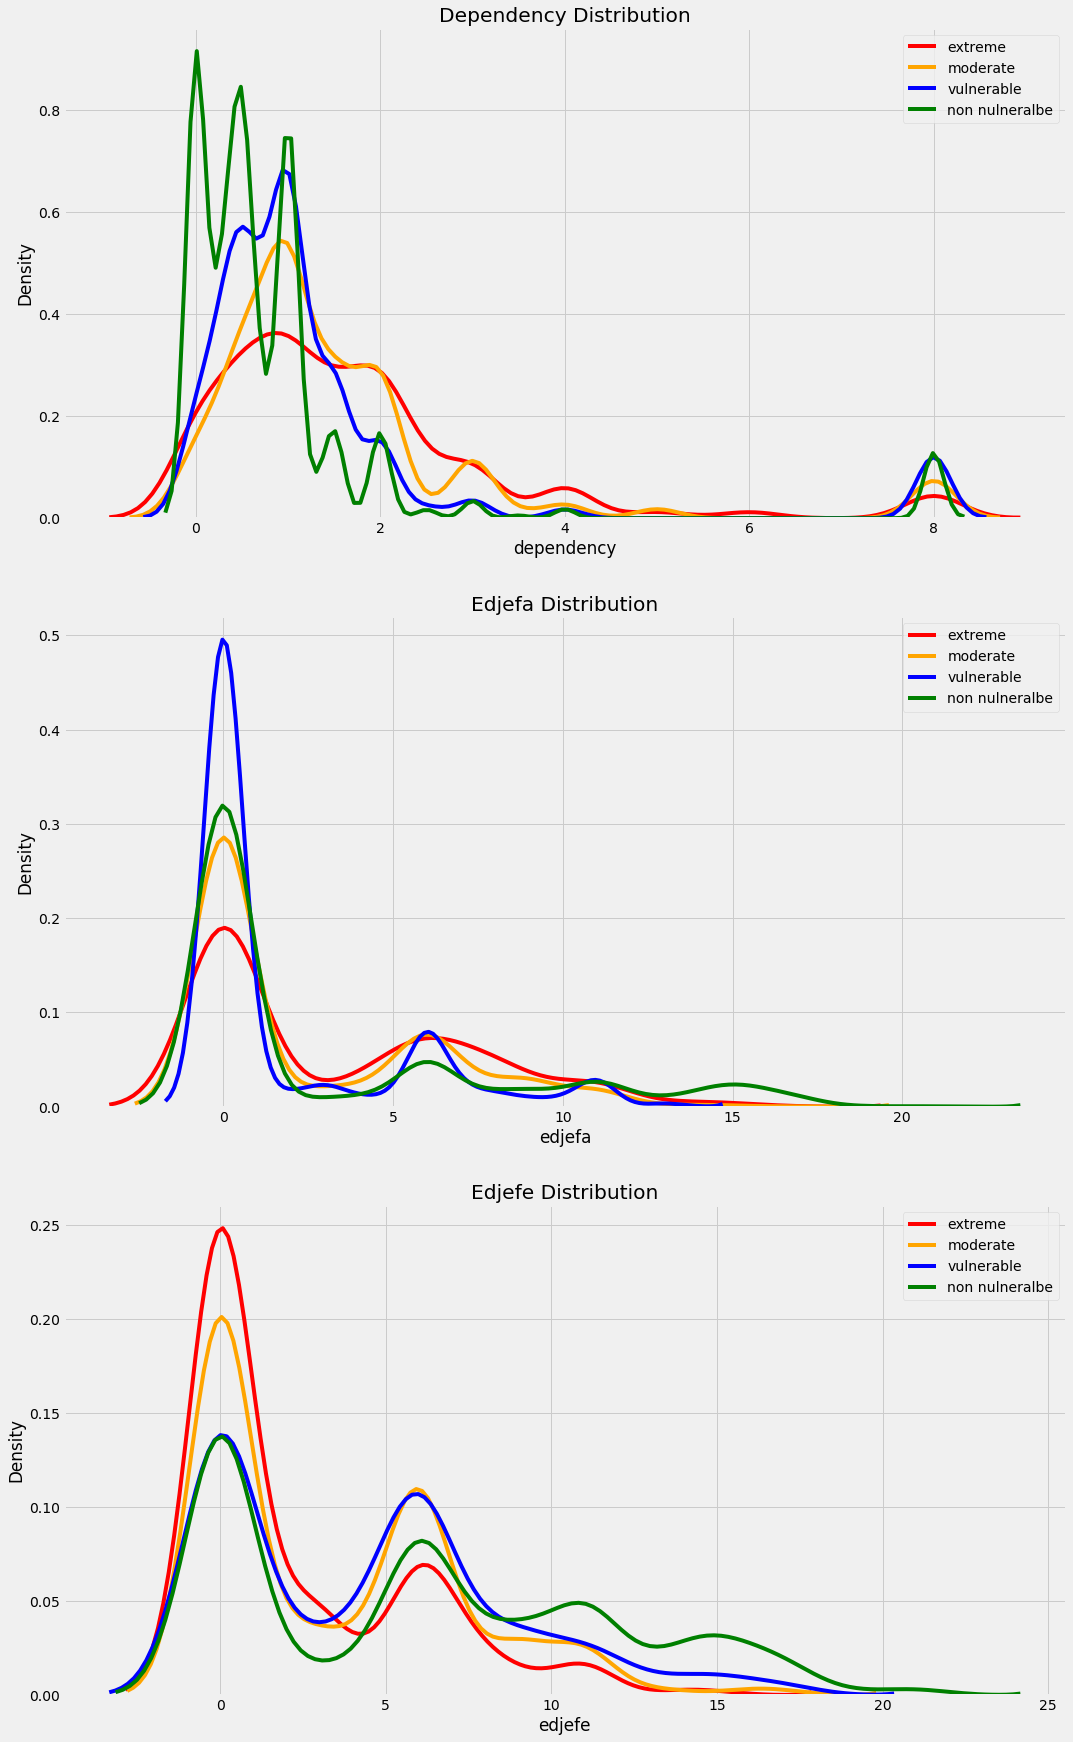

In [10]:
plt.figure(figsize = (16,12))
## 연속형 변수 반복

for i, col in enumerate(['dependency','edjefa','edjefe']):
    ax = plt.subplot(3,1,i+1)
    # 타켓변수 속성 반복
    for poverty_level, color in colors.items():
        sns.kdeplot(train.loc[train['Target'] ==poverty_level, col].dropna(),
                   ax =ax , color =color , label =poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Density')
plt.subplots_adjust(top=2)
               
    

 - 명목형 변수를 수치형 변수로 변환함으로써 올바른 데이터 정보를 얻을 수 있다.

In [10]:
## test set의 Target 변수 null값 입력
test['Target'] =np.nan
data =train.append(test,ignore_index =True)

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

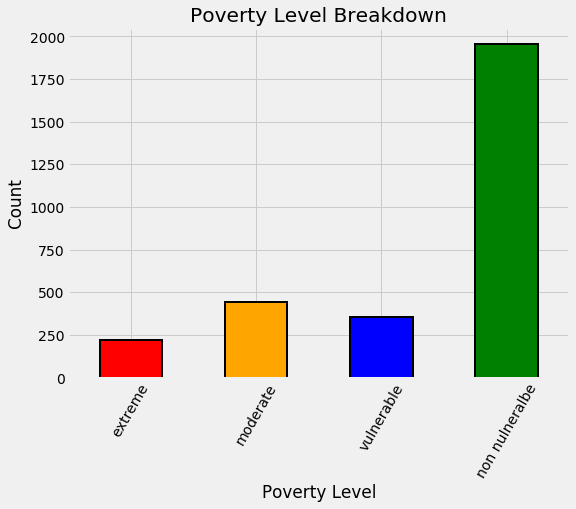

In [11]:
## 타켓변수의 분포 확인

## 세대주
Heads =data.loc[data['parentesco1'] == 1].copy()

## traom set 라벨링 
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target','idhogar']]

## 타켓 속성 게산
label_counts = train_labels['Target'].value_counts().sort_index()

## Bar plot 
label_counts.plot.bar(figsize =(8,6),
                     color = colors.values(),
                     edgecolor = 'k', linewidth =2)

plt.xlabel('Poverty Level')
plt.ylabel('Count')
plt.xticks([x -1 for x in poverty_mapping.keys()],
          list(poverty_mapping.values()), rotation = 60)
plt.title('Poverty Level Breakdown')

label_counts

### 불균형 분류 문제
 - 정확도가 높아도 적은 클래스의 재현율이 급격히 작아지는 현상이 발생
 - 극심한 빈곤층에 수가 적어 파악하기 힘듬
 
### 샘플링 방법을 사용
 - 오버샘플링 : 소수 글래스를 증가시키는 방법 
 - 언더샘플링 : 다수 클래스의 일부만 사용하는 방법
 

In [12]:
## 세대주로 그룹화
all_equal= train.groupby('idhogar')['Target'].apply(lambda x:x.nunique() ==1)

## 
not_equal = all_equal[all_equal != True]
print('There are{} households where the family members do not all have same target.'.format(len(not_equal)))

There are85 households where the family members do not all have same target.


In [13]:
train[train['idhogar'] == not_equal.index[0]][['idhogar','parentesco1','Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


주최측은 올바른 레이블이 parentesco1 == 1 인 세대주를위한 레이블이라고 말합니다.이 세대의 경우 모든 구성원에 대해 올바른 레이블은 3입니다. 우리는이 가구의 모든 개인을 올바른 빈곤 수준으로 재 할당함으로써 (나중에 보여지는 바와 같이)이를 수정할 수 있습니다. 실제로는 직접 또는 팀의 도움을 받아 문제를 해결하는 방법을 결정해야 할 수도 있습니다.


세대주가없는 가족
동일한 세대의 개인에게 세대주 레이블을 할당하여 모든 상표 불일치를 수정할 수 있습니다. 그러나 기다릴 수 있습니다. "가족이없는 가구가 있다면 어떻습니까? 그 가구 구성원의 레이블 값이 다른 경우 어떻게해야합니까?"

글쎄, 당신이 요청한 이후에, 그 질문을 정확하게 조사합시다!

In [14]:
households_leader = train.groupby('idhogar')['parentesco1'].sum()

## 세대주 없는 가족구성원 찾기
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader == 0].index), :]

print('There are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

There are 15 households without a head.


In [15]:
## 세대주가 없고 다른 레이블에 있는 가족구성원 찾기
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x:x.nunique() ==1)
print('{} Households with no head have different labels.'.format(sum(households_no_head_equal ==False)))

0 Households with no head have different labels.


글쎄, 그것은 구호입니다! 이것은 우리가 머리가없고 구성원의 레이블 값이 다른 가정에 대해 걱정할 필요가 없음을 의미합니다! 이 문제에 대해 주최자에 따르면 가구에 머리가 없으면 진정한 레이블이 없습니다. 따라서 우리는 실제로 훈련을 위해 머리를 쓰지 않고 어떤 가구도 사용하지 않을 것입니다. 그럼에도 불구하고 데이터 조사 과정을 거치는 것이 여전히 좋은 운동입니다!


이제 우리는 머리가있는 가구와 빈곤층이 다른 가구에 대한 레이블을 수정할 수 있습니다.


In [16]:
# 각 가정 반복

for household in not_equal.index:
    ## 
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] ==1.0)]['Target'])
    ## 가족 구성원의 라벨 수정하기
    train.loc[train['idhogar'] == household, 'Target'] = true_target

all_equal = train.groupby('idhogar')['Target'].apply(lambda x:x.nunique() ==1)
# 
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 0 households where the family members do not all have the same target.


레이블에는 세대주 만 사용하기 때문에이 단계는 완전히 필요한 것은 아니지만 실제 상황에서 발생할 수있는 데이터 오류를 수정하는 워크 플로우를 보여줍니다. 추가 작업을 고려하지 말고 경력을 위해 연습하십시오!


## 결측값
 - v18q1
 - v2a1

In [17]:
# 각 변수의 결측치 수 
missing = pd.DataFrame(data.isnull().sum()).rename(columns ={0 : 'total'})

#백분율 계산 
missing['percent'] = missing['total']/len(data)

missing.sort_values('percent',ascending =False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


결측값이 높은 상위 3개에대해서 수정이 필요함

v18q1 : 가족이 소유 한 태블릿 수
 - 가계변수이기 때문에 가계수준만 고려해야 함 


In [18]:
def plot_value_counts(df,col, heads_only =False):
    # 세대주 선택
    if heads_only:
        df = df.loc[df['parentesco1'] == 1].copy()
        
    plt.figure(figsize =(8,6))
    df[col].value_counts().sort_index().plot.bar(color ='blue',
                                                edgecolor ='k',
                                                linewidth = 2)
    plt.xlabel(f'{col}')
    plt.title(f'{col} Value Counts')
    plt.ylabel('Count')
    plt.show()

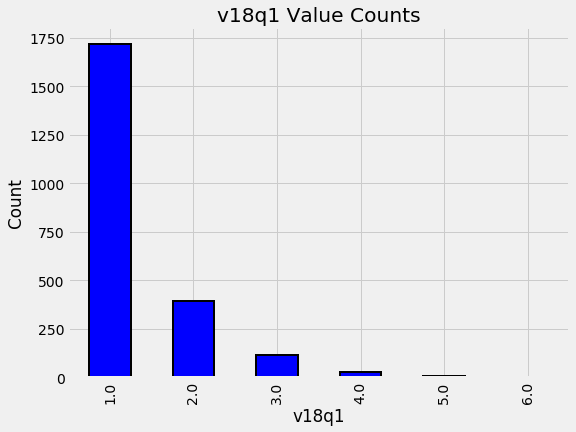

In [19]:
plot_value_counts(Heads,'v18q1')

존재하는 데이터 만 사용하는 경우 가장 일반적인 태블릿 수는 1 인 것 같습니다. 그러나 누락 된 데이터에 대해서도 고려해야합니다. 이 경우,이 카테고리의 난이를 가진 가족은 태블릿을 소유하지 않을 수 있습니다! 데이터 정의를 보면 v18q가 가족이 태블릿을 소유하고 있는지 여부를 나타냅니다. 이 칼럼을 여러 태블릿과 결합하여 가설이 유지되는지 확인해야합니다.

v18q의 값을 그룹화하여 (태블릿의 경우 1, 그렇지 않은 경우 0) v18q1의 null 값 수를 계산할 수 있습니다. 이것은 null 값이 가족이 태블릿을 소유하지 않음을 나타내는 지 알려줍니다.

In [20]:
Heads.groupby('v18q')['v18q1'].apply(lambda x:x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64


글쎄, 그 문제를 해결! v18q1에 대해 nan이있는 모든 가족은 태블릿을 소유하지 않습니다. 따라서이 결 측값을 0으로 채울 수 있습니다.

In [21]:
data['v18q1'] =data['v18q1'].fillna(0)


v2a1 : 월 임대료 지불

다음으로 누락 된 열은 월 임대료 지불을 나타내는 v2a1입니다.

월 임대료의 누락 된 가치를 살펴 보는 것 외에도 주택의 소유권 / 임대 상태를 나타내는 열인 tipovivi_의 분포를 살펴 보는 것도 흥미로울 것입니다. 이 그림의 경우, 월 임대료 지불에 대해 난이있는 주택의 소유권 상태를 보여줍니다.

Text(0.5, 1.0, 'Home Ownership Status for Households Missing Rent Payments')

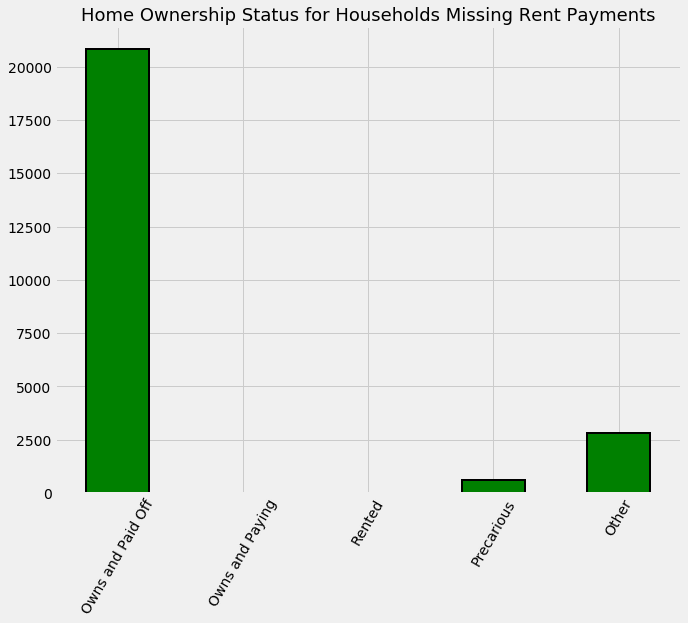

In [22]:
# 주택 소유를 나타내는 변수

own_variables = [ x for x in data if x.startswith('tipo')]

# 월 임대료 지불에 대한 주택 소유 변수 그래프
data.loc[data['v2a1'].isnull(),own_variables].sum().plot.bar(figsize = (10,8),
                                                            color = 'green',
                                                            edgecolor ='k',
                                                            linewidth = 2)
plt.xticks([0,1,2,3,4],
          ['Owns and Paid Off', 'Owns and Paying', 'Rented','Precarious','Other'],
          rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size =18)


우리는 문제를 해결했습니다! 글쎄, 주로 : 월세를 지불하지 않는 가구는 일반적으로 자신의 집을 소유합니다. 다른 상황에서는 정보가 누락 된 이유를 확신 할 수 없습니다.

소유하고 월 임대료가 누락 된 주택의 경우 임대료 지불액을 0으로 설정할 수 있습니다. 다른 주택의 경우 결 측값을 대치 할 수 있지만 해당 가정에 결 측값이 있음을 나타내는 플래그 (부울) 열을 추가합니다

In [23]:
#
data.loc[(data['tipovivi1'] == 1), 'v2a1'] =0

# 월 임대료 지불 결측값 컬럼 추출
data['v2a1-missing'] = data['v2a1'].isnull()
data['v2a1-missing'].value_counts()


False    29994
True      3419
Name: v2a1-missing, dtype: int64

rez_esc : 학교에서 몇 년 뒤에

결 측값 비율이 높은 마지막 열은 rez_esc이며 학교에서 몇 년이 지났음을 나타냅니다. null 값을 가진 가정의 경우 현재 학교에 자녀가 없을 가능성이 있습니다. 이 열에서 결 측값이없는 사람의 연령과 결 측값이없는 사람의 연령을 찾아이를 테스트 해 봅시다.

In [24]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

이것이 우리에게 알려주는 것은 가장 가치가없는 나이가 17 세라는 것입니다. 이보다 나이가 많은 사람은 아마도 학교에 있지 않다고 가정 할 수 있습니다. 가치가없는 사람들의 나이를 봅시다.


In [25]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

우리가이 경쟁에 대한 토론을 읽으면,이 변수는 7과 19 사이의 개인에 대해서만 정의된다는 것을 알게됩니다.이 범위보다 젊거나 더 오래된 사람은 아마도 몇 년 뒤가 없기 때문에 그 값은 0으로 설정되어야합니다. 이 변수는 개인이 19 세 이상이고 결 측값이 있거나 7보다 작고 결 측값이있는 경우 0으로 설정할 수 있습니다. 다른 사람에게는 값을 대치하고 부울 플래그를 추가합니다.


In [26]:
# 
data.loc[((data['age']>19)|(data['age']<7))& (data['rez_esc'].isnull()),'rez_esc'] = 0

# 7~19 사이 결측값 
data['rez_esc-missing'] = data['rez_esc'].isnull()

rez_esc 열에는 특이 치가 하나 있습니다. 다시 한 번 경쟁 토론을 읽으면이 변수의 최대 값이 5임을 알게됩니다. 따라서 5보다 큰 값은 5로 설정해야합니다.


In [27]:
data.loc[data['rez_esc'] >5, 'rez_esc'] =5

Plot Two Categorical Variables
To show how two categorical variables interact with one another, there are a number of plotting options: scatterplots, faceted bar plots, boxplots, etc. I wasn't satisfied with any of these choices so I wrote the function below, which essentially is a scatterplot of two categoricals where the size of the points represent the percentage of a given y-value represented by each x-value.

## 범주형 그래프
- 2가지 범주형 변수 요소에 대한 그래프 

In [28]:
def plot_categoricals(x,y,data, annotate = True):  # annotate : 텍스트를 표시
    
    ## 합 계산 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    ## x,y 각 그룹에 대해서 합 계산
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    ## 컬럼 재설정
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100*counts['normalized_count']
    
    ## 합 계산 더하기
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    
    ## 백분율로 크기 표현
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
               s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
               alpha = 0.6, linewidth =1.5)
    
    if annotate:
        ## 텍스트 주석
        for i, row in counts.iterrows(): ## 행번호와 값 출력
            #
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()),
                              row[y] - (0.15 /counts[y].nunique())),
                        color ='navy',
                        s =f"{round(row['percent'], 1)}%")
    plt.yticks(counts[y].unique())             
    plt.xticks(counts[x].unique())
    
    #
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))

    # 각 범례 크기 조절
    msizes = list(range(sqr_min, sqr_max,int(( sqr_max - sqr_min)/5)))
    
    markers = []
    
    #범례
    for size in msizes:
        makers.append(plt.scatter([],[], s = 100*size,
                                 label =f'{int(round(np.square(size)/100)*100)}',
                                 color = 'lightgreen',
                                 alpha = 0.6, edfecolor ='k', linewidth =1.5))
    # 범례
    plt.legend(handles = markers, title = 'Counts',
              labelspacing =3, handletextpad = 2,
              fontsize = 16,
              loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                xy= (0,1), xycoords = 'figure points', size =10)
    #
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()),
            counts[x].max() + (6/ counts[x].nunique())))
    plt.ylim((counts[y].min() - (6 / counts[y].unique()),
             counts[y]/max() + (6/counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}")
    plt.ylabel(f"{y}")
    plt.title(f"{y} vs {x}")



In [29]:
def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

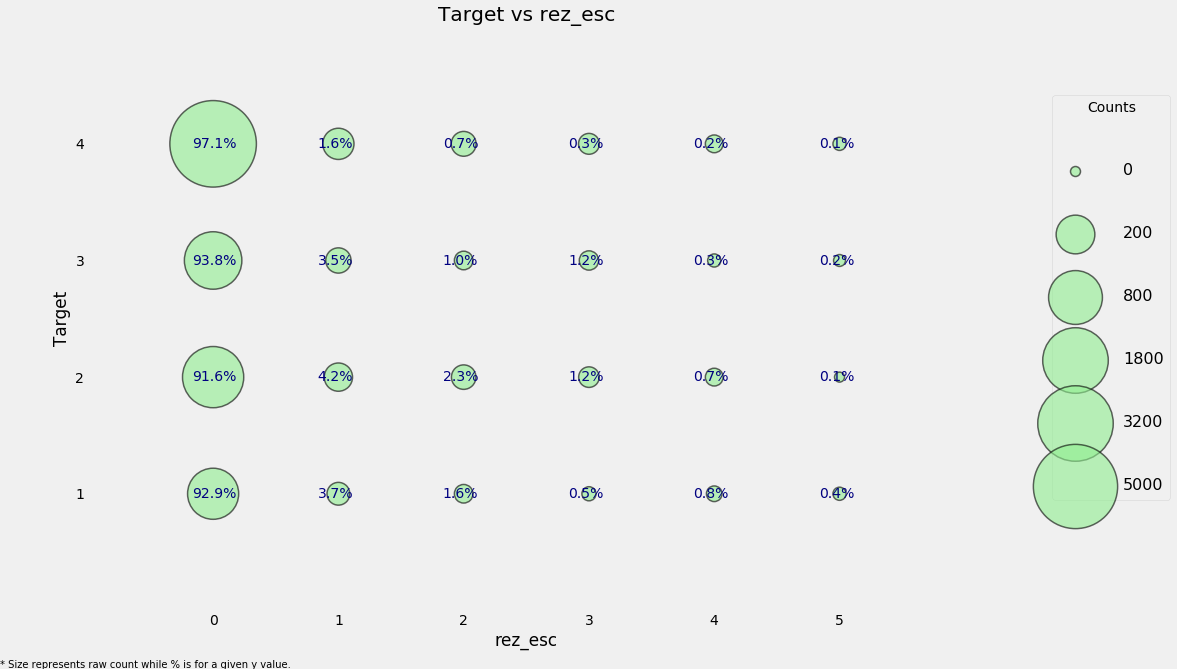

In [30]:
plot_categoricals('rez_esc','Target',data)

마커의 크기는 원시 수를 나타냅니다. 그림을 읽으려면 주어진 y 값을 선택한 다음 행을 읽습니다. 예를 들어, 빈곤 수준이 1 인 경우, 개인의 93 %가 총 800 명으로 총 수는 뒤지지 않으며, 약 0.4 %의 개인이 5 년 뒤에이 범주에서 약 50 명의 개인이 있습니다. 이 플롯은 전체 개수와 범주 내 비율을 모두 표시하려고 시도합니다. 완벽하지는 않지만 나는 그것을 쐈다!


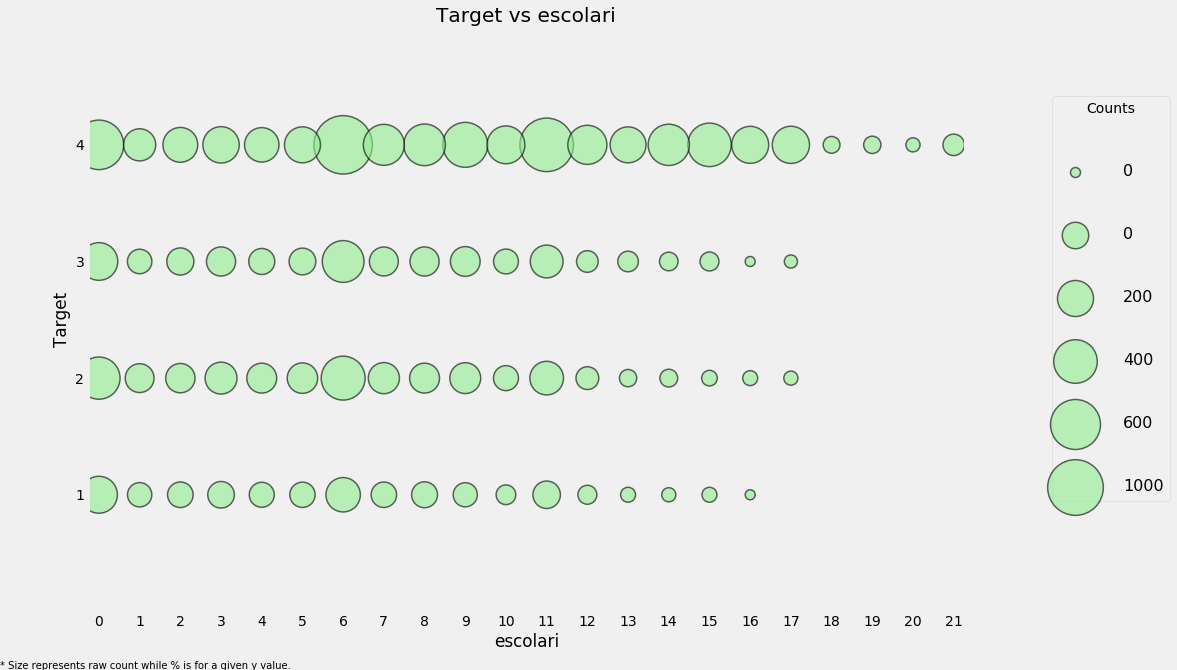

In [31]:
plot_categoricals('escolari','Target',data,annotate = False)

각 열의 나머지 결 측값은 대치로 알려진 프로세스로 채워집니다. 일반적으로 사용되는 몇 가지 유형의 대치가 있으며 가장 간단하고 효과적인 방법 중 하나는 열의 중앙값으로 결 측값을 채우는 것입니다.
결 측값이있는 최종 단계로,이 값 중 하나가 결측 된 경우에 대한 대상 분포를 플로팅 할 수 있습니다.


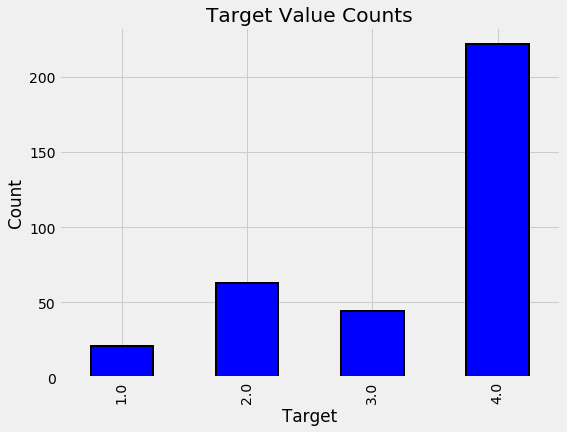

In [32]:
plot_value_counts(data[(data['rez_esc-missing'] == 1)],
                 'Target')

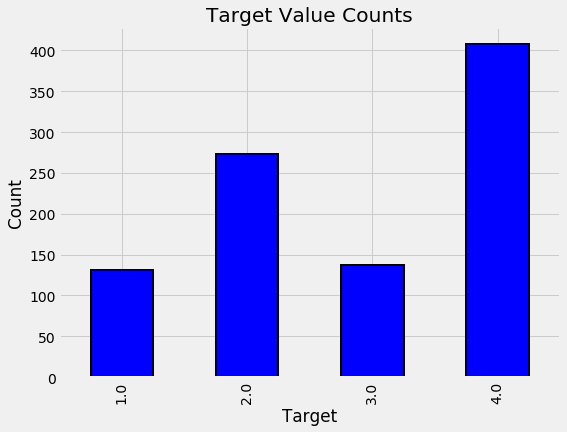

In [33]:
plot_value_counts(data[(data['v2a1-missing']== 1)], 'Target')

이것은 빈곤율이 보통 인 빈곤율이 높을수록 빈곤의 지표가 될 수있는 것처럼 보인다.

이것은 중요한 요점을 나타냅니다. 때로는 누락 된 정보가 귀하가 제공 한 정보만큼 중요합니다.

## Feature Engineering
더 많은 탐색 적 데이터 분석이 가능하지만 먼저 데이터를 가구 수준에서 통합하는 작업을해야합니다. 우리는 이미 각 가정에 대한 정보를 가지고 있지만 훈련을 위해서는 각 가정에 대해 요약 된 모든 정보가 필요합니다. 즉, 개인을 집에서 그룹화 (groupby)하고 개별 변수의 집계 (agg)를 수행합니다.

다른 노트북에서는 자동화 된 기능 엔지니어링을 사용하여이를 수행하는 방법을 보여 주며 자동화 된 기능 엔지니어링은 기계 학습 워크 플로우의 표준 부분이어야합니다. 지금 당장은이 작업을 직접 수행하지만 Featuretools의 자동화 된 기능 엔지니어링을 살펴보십시오.

열 정의
때로는 데이터 과학에서 데이터를 더 럽히거나 많은 시간이 걸리는 지루한 작업을 수행해야합니다. 이는 분석의 일부입니다. 데이터 설명을 사용하여 개별 수준과 가구 수준에있는 열을 정의해야합니다. 데이터 설명에서 변수 자체를 통과하는 것보다 가구 수준의 변수를 식별하는 다른 방법은 없습니다. 이미이 작업은 이미 완료되었으므로 복사하여 붙여 넣기 만하면됩니다.

우리는 다른 변수를 정의 할 것인데, 그중 일부는 다른 방식으로 처리해야하기 때문입니다. 각 수준에 변수가 정의되면 필요에 따라 집계를 시작할 수 있습니다.

과정은 다음과 같습니다


변수를 세대 수준과 개인 수준으로 나누기

개별 레벨 데이터에 적합한 집계 찾기

서수 변수는 통계 집계를 사용할 수 있습니다

부울 변수도 집계 할 수 있지만 통계는 더 적습니다.

가구 단위 데이터에 개별 집계에 참여


변수 범주 정의


여러 가지 범주의 변수가 있습니다.

개인 변수 : 이들은 가정이 아닌 각 개인의 특성입니다


부울 : 예 또는 아니오 (0 또는 1)


순서 이산 : 순서가있는 정수


가구 변수


부울 : 예 또는 아니요

순서 이산 : 순서가있는 정수

연속 숫자

제곱 변수 : 데이터의 제곱 변수에서 파생

ID 변수 : 데이터를 식별하며 기능으로 사용해서는 안됩니다
아래에서 각 범주의 변수를 수동으로 정의합니다. 이것은 약간 지루하지만 필요합니다.

In [34]:
id_ = ['Id', 'idhogar', 'Target']

In [35]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

In [36]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [37]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

In [38]:
x = ind_bool +ind_ordered+id_+hh_bool+hh_ordered+hh_cont+sqr_

from collections import Counter

print('There are no repeats :', np.all(np.array(list(Counter(x).values())) == 1))
print('We covered every variable:', len(x) == data.shape[1])

There are no repeats : True
We covered every variable: True


먼저 가장 쉬운 단계는 모든 제곱 변수를 제거하는 것입니다. 선형 모델이 비선형 관계를 학습하는 데 도움이되기 때문에 변수는 형상 공학의 일부로 제곱 또는 변형되는 경우가 있습니다. 그러나보다 복잡한 모델을 사용하므로 이러한 제곱 기능은 중복됩니다. 그것들은 비 제곱 버전과 높은 상관 관계가 있으므로 관련없는 정보를 추가하고 훈련 속도를 늦춤으로써 실제로 모델을 손상시킬 수 있습니다.


Text(0.5, 1, 'Squared Age versus Age')

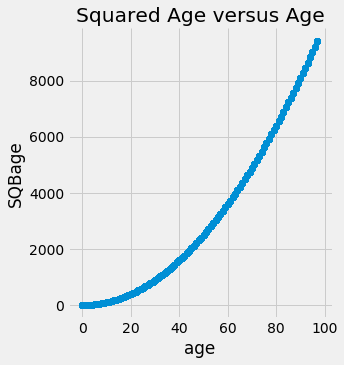

In [39]:
sns.lmplot('age','SQBage',data = data, fit_reg = False)
plt.title('Squared Age versus Age')

이러한 변수는 서로 밀접하게 관련되어 있으며 데이터에 둘 다 유지할 필요는 없습니다.


In [40]:
data = data.drop(columns =sqr_)
data.shape

(33413, 136)


세대 수준 변수
먼저 세대주와 하위 세대 수준의 하위 집합을합시다.

In [41]:
heads =data.loc[data['parentesco1'] == 1, :]
heads = heads[id_ + hh_bool + hh_cont +hh_ordered]
heads.shape

(10307, 99)

가구 수준 변수의 대부분은 그대로 유지하면됩니다. 각 가구에 대해 예측을하기 위해 이러한 변수를 기능으로 사용합니다. 그러나 일부 중복 변수를 제거하고 기존 데이터에서 파생 된 기능을 추가 할 수도 있습니다.

중복 가계 변수
모든 가계 변수 간의 상관 관계를 살펴 보겠습니다. 상관 관계가 너무 높은 경우 상관 관계가 높은 변수 쌍 중 하나를 제거 할 수 있습니다.

다음 코드는 0.95보다 큰 절대 크기 상관 관계를 갖는 변수를 식별합니다.

In [42]:
# 상관계수 산출
corr_matrix = heads.corr()

#
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k =1).astype(np.bool))

#
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

이들은 각 상관 변수 쌍 중 하나를 보여줍니다. 다른 쌍을 찾기 위해 corr_matrix를 부분 집합 할 수 있습니다.

In [43]:
corr_matrix.loc[corr_matrix['tamhog'].abs() >0.9, corr_matrix['tamhog'].abs() > 0.9]

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998287,0.910457,0.998287,0.998287
tamhog,0.998287,1.000000,0.909155,1.000000,1.000000
tamviv,0.910457,0.909155,1.000000,0.909155,0.909155
hhsize,0.998287,1.000000,0.909155,1.000000,1.000000
hogar_total,0.998287,1.000000,0.909155,1.000000,1.000000


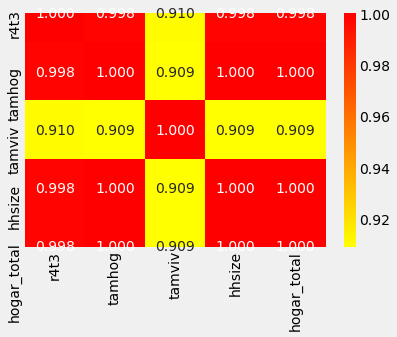

In [44]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs()>0.9],
           annot = True, cmap =plt.cm.autumn_r, fmt = '.3f')

집의 크기와 관련된 몇 가지 변수가 있습니다.

r4t3, 세대 전체 인원
tamhog, 세대 규모
탬 비브, 세대에 살고있는 사람의 수
hhsize, 세대 규모
hogar_total, 세대의 총 개인 수
이러한 변수는 모두 서로 밀접하게 관련되어 있습니다. 실제로 hhsize는 tamhog 및 hogar_total과 완벽한 상관 관계가 있습니다. 정보가 중복되므로이 두 변수를 제거합니다. r4t3은 hhsize와 거의 완벽한 상관 관계가 있으므로 제거 할 수도 있습니다.

tamviv는 가정에 살고 있지 않은 가족 구성원이있을 수 있기 때문에 hhsize와 반드시 동일하지는 않습니다. 산점도에서이 차이를 시각화 해 봅시다.

In [45]:
heads = heads.drop(columns = ['tamhog','hogar_total','r4t3'])

C:\Users\USER\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1, 'Household size vs number of persons living in the household')

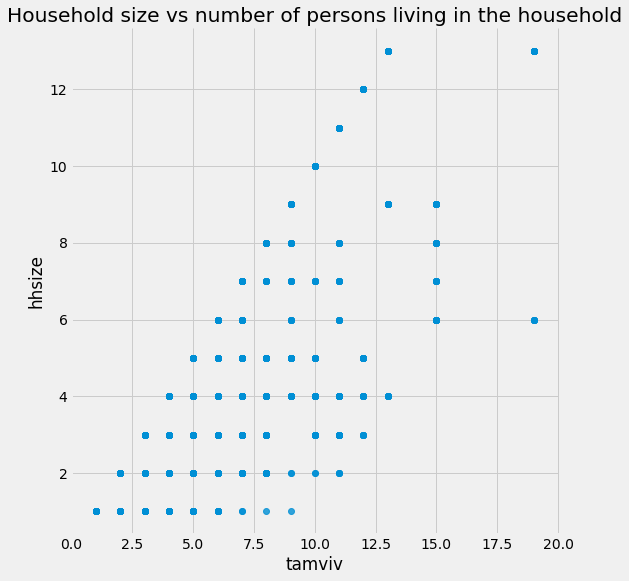

In [46]:
sns.lmplot('tamviv','hhsize',data,fit_reg = False, size =8)
plt.title('Household size vs number of persons living in the household')


우리는 많은 경우에 가족보다 가족에 더 많은 사람들이 살고 있습니다. 이를 통해 새로운 기능에 대한 좋은 아이디어를 얻을 수 있습니다.이 두 측정의 차이점!

이 새로운 기능을 만들어 봅시다.

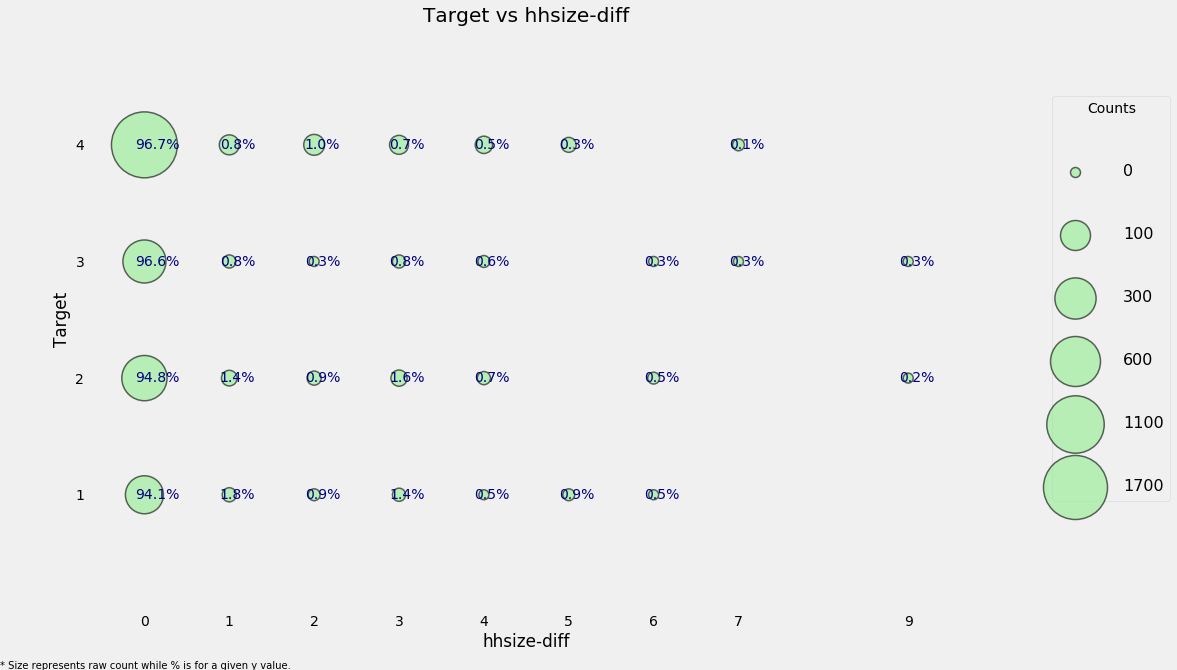

In [47]:
heads['hhsize-diff'] = heads['tamviv'] -heads['hhsize']
plot_categoricals('hhsize-diff','Target',heads)

대부분의 가정에는 차이가 없지만 가정 구성원보다 가정에 더 많은 사람들이 살고 있습니다.

다른 중복 변수로 넘어 갑시다. 먼저 우리는 coopele를 볼 수 있습니다

In [48]:
corr_matrix.loc[corr_matrix['coopele'].abs()> 0.9, corr_matrix['coopele'].abs()>0.9]

,public,coopele
public,1.000000,-0.967759
coopele,-0.967759,1.000000


이 변수는 가정의 전기가 어디에서 나오는지 나타냅니다. 네 가지 옵션이 있으며이 두 가지 옵션 중 하나가없는 가족은 전기가 없거나 (noelec) 개인 공장에서 가져옵니다 (planpri).

서수 변수 만들기
순서 변수를 작성하여이 네 가지 변수를 하나로 압축합니다. 데이터 설명에 따라 직접 매핑을 선택하겠습니다.


정렬 된 변수에는 고유 한 순서가 있으며,이를 위해 우리는 도메인 지식을 기반으로 자체 변수를 선택합니다. 이 새로운 정렬 변수를 생성 한 후 다른 4 개의 변수를 삭제할 수 있습니다. 여기에 변수가없는 여러 세대가 있으므로 nan (대치 중에 채워질)을 사용하고이 변수에 대한 측정이 없음을 나타내는 부울 열을 추가합니다.

In [49]:
elec =[]
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] ==1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] ==1:
        elec.append(3)
    else:
        elec.append(np.nan)
#
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()


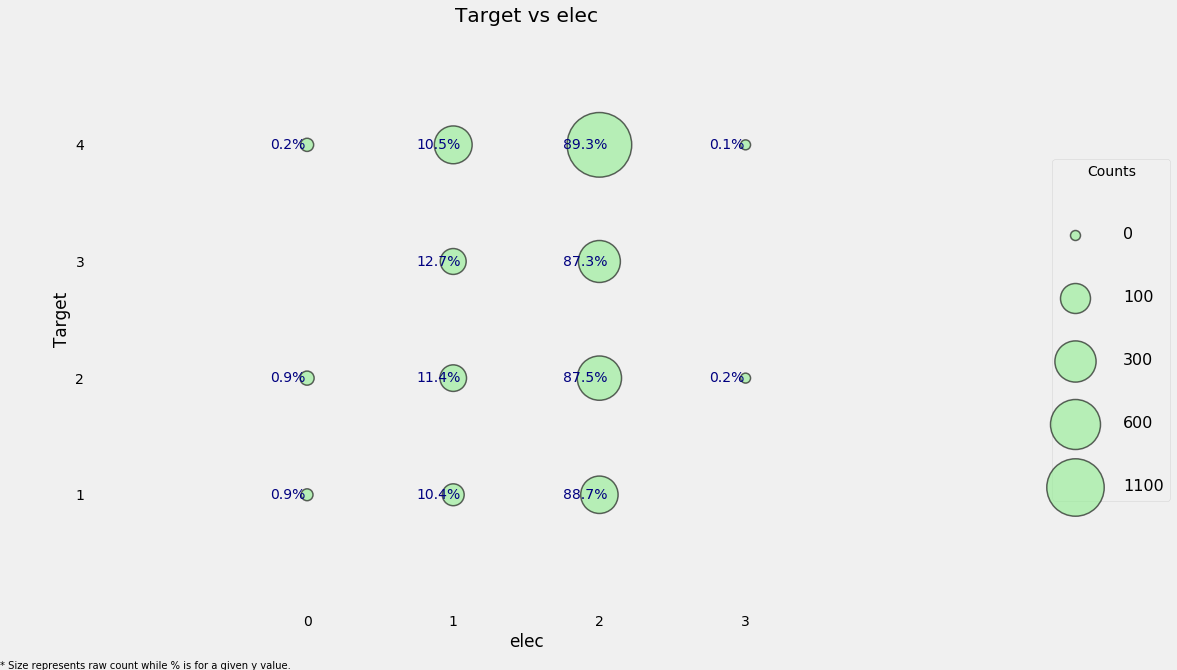

In [50]:
plot_categoricals('elec','Target',heads)

Target의 모든 가치에 대해 가장 일반적인 전기 공급원은 나열된 공급 업체 중 하나에서 나온 것입니다.

마지막 중복 열은 area2입니다. 이것은 집이 농촌 지역에 있지만 집이 도시 지역에 있는지를 나타내는 기둥이 있기 때문에 중복됩니다. 따라서이 열을 삭제할 수 있습니다.

In [51]:
heads = heads.drop(columns = 'area2')

heads.groupby('area1')['Target'].value_counts(normalize =True)

area1  Target
0      4.0       0.582249
       2.0       0.176331
       3.0       0.147929
       1.0       0.093491
1      4.0       0.687030
       2.0       0.137688
       3.0       0.108083
       1.0       0.067199
Name: Target, dtype: float64

도시 지역 (가치 1)의 가구는 농촌 지역 (가치 0)의 가구보다 빈곤율이 낮을 것으로 보인다.

서수 변수 만들기
집의 벽, 지붕 ​​및 바닥에는 각각 세 개의 열이 있습니다. 첫 번째는 '나쁜', 두 번째는 '일반', 세 번째는 '좋은'을 나타냅니다. 우리는 변수를 부울로 남겨 둘 수는 있지만 나에게 본질적인 순서가 있기 때문에 변수를 서수 변수로 바꾸는 것이 더 합리적입니다. bad <regular <good. 이를 위해 np.argmax를 사용하여 각 가정에서 0이 아닌 열을 간단히 찾을 수 있습니다.

서수 변수를 만들면 원래 변수를 삭제할 수 있습니다.

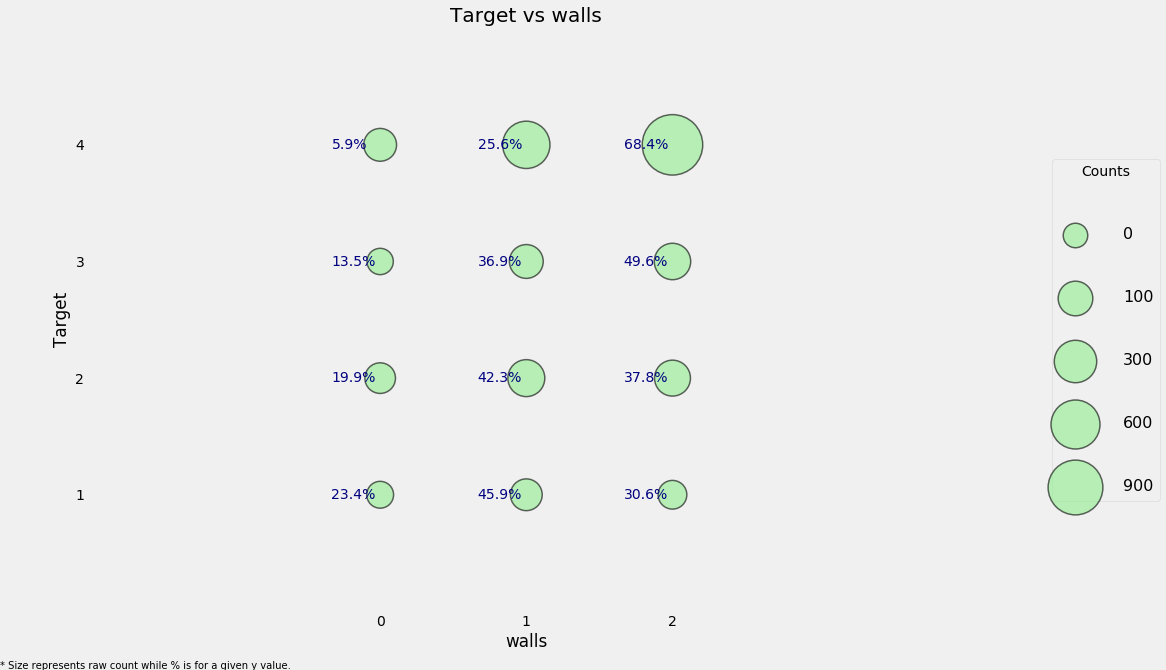

In [52]:
heads['walls'] = np.argmax(np.array(heads[['epared1','epared2','epared3']]),
                          axis =1)

plot_categoricals('walls','Target',heads)

In [53]:
#
heads['roof'] = np.argmax(np.array(heads[['etecho1','etecho2','etecho3']]),
                         axis =1)
heads=heads.drop(columns = ['etecho1','etecho2','etecho3'])

heads['floor'] = np.argmax(np.array(heads[['eviv1','eviv2','eviv3']]),
                          axis =1)

기능 구성
변수를 서수 피처에 매핑하는 것 외에도 피처 생성이라고하는 기존 데이터에서 완전히 새로운 피처를 만들 수도 있습니다. 예를 들어, 집 구조의 품질을 전체적으로 측정하기 위해 방금 만든 이전 세 가지 기능을 추가 할 수 있습니다.

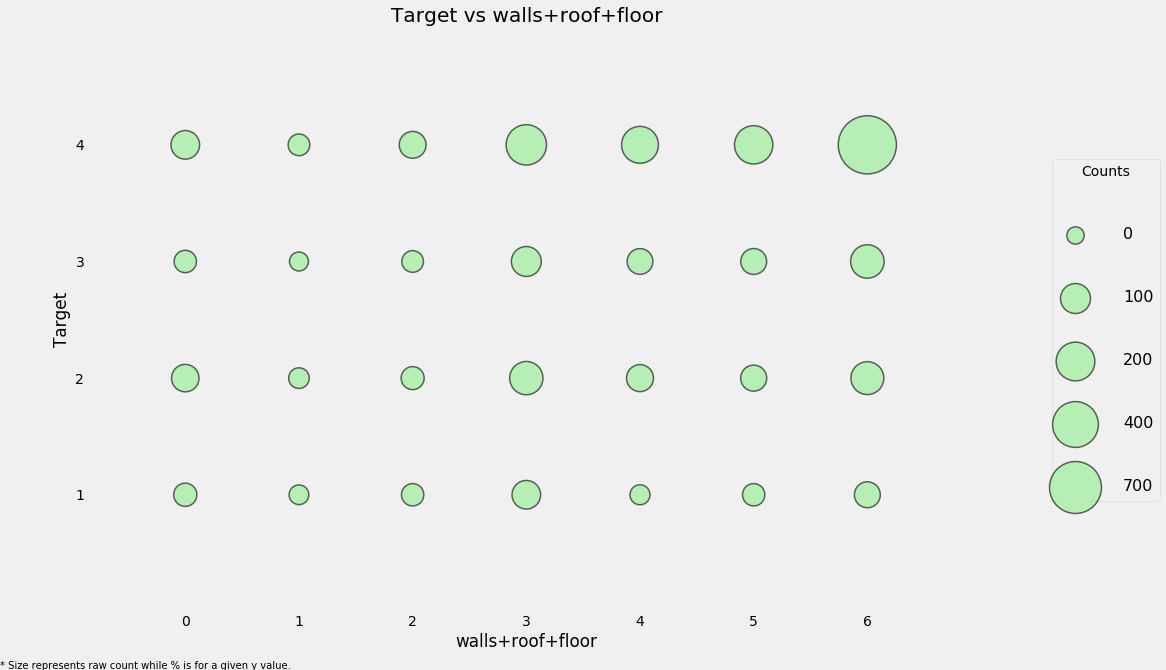

In [54]:
## 파생변수 생성
heads['walls+roof+floor'] = heads['walls'] +heads['roof'] +heads['floor']
plot_categoricals('walls+roof+floor','Target',heads, annotate = False)

In [55]:
counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(normalize = True)).rename(columns = {'Target':'Normalized Count'}).reset_index()
counts.head()

,walls+roof+floor,Target,Normalized Count
0,0,4.0,0.376404
1,0,2.0,0.320225
2,0,1.0,0.162921
3,0,3.0,0.140449
4,1,4.0,0.323529


In [56]:
heads['warning'] = 1*(heads['sanitario1'] +
                     (heads['elec'] == 0)+
                     (heads['pisonotiene'] +
                     heads['abastaguano']+
                     (heads['cielorazo'] == 0)))

Text(0.5, 1.0, 'Target vs Warning Variable')

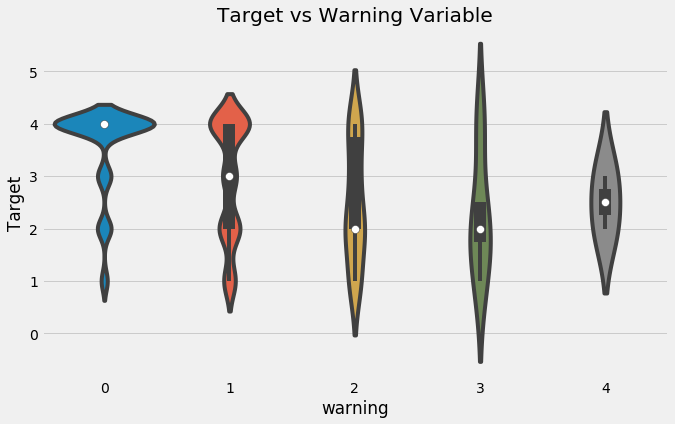

In [57]:
plt.figure(figsize = (10,6))
sns.violinplot(x= 'warning', y= 'Target', data = heads)
plt.title('Target vs Warning Variable')

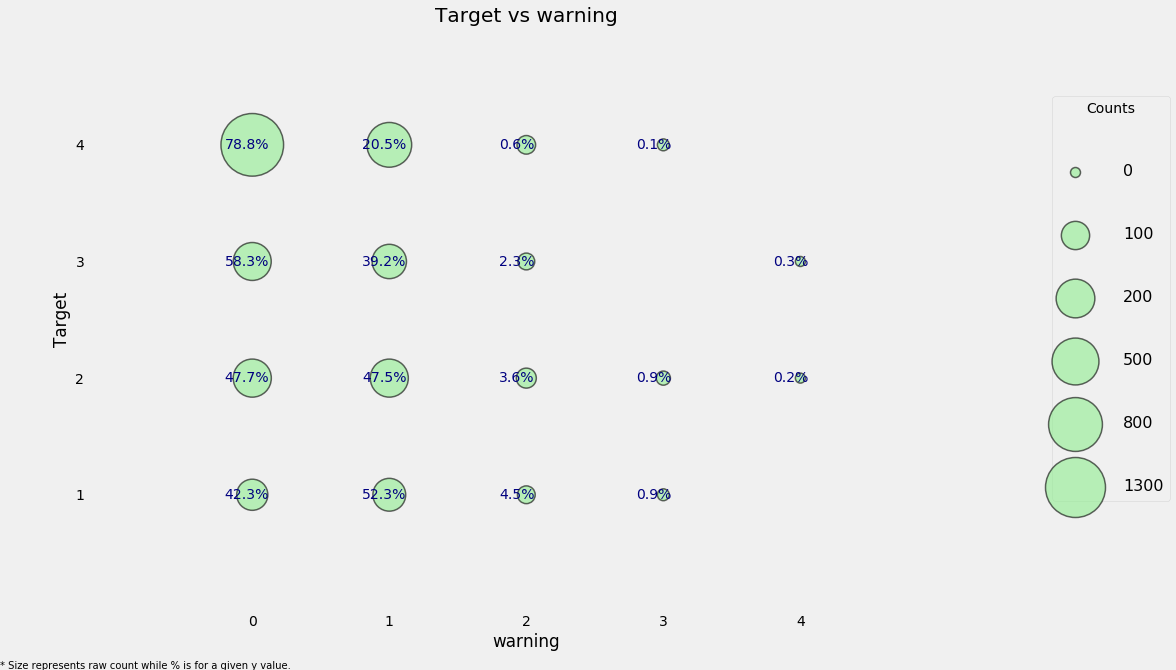

In [58]:
plot_categoricals('warning','Target',data =heads)

바이올린 플롯은 대상이 실제로보다 더 작고 더 큰 가치를 취할 수있는 것처럼 보이는 효과로 범주 변수를 부드럽게하기 때문에 여기서 좋지 않습니다. 그럼에도 불구하고, 우리는 경고 표시가없고 빈곤 수준이 가장 낮은 고집적 가구를 볼 수 있습니다. 이것이 유용한 기능인 것처럼 보이지만 모델링에 도달 할 때까지 확실하게 알 수 없습니다!

우리가 지금 할 수있는 마지막 세대의 특징은 가족이 냉장고, 컴퓨터, 태블릿 또는 텔레비전을 가지고 있다는 점을 얻는 보너스입니다.

Text(0.5, 1.0, 'Target vs Bonus Variable')

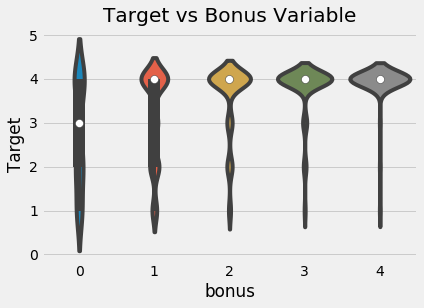

In [59]:
heads['bonus'] = 1*(heads['refrig']+
                   heads['computer']+
                   (heads['v18q1']>0)+
                   heads['television'])
sns.violinplot('bonus','Target',data = heads,
              figsize = (10,6))
plt.title('Target vs Bonus Variable')

추가 기능으로 가정의 각 개인에 대한 특정 측정 수를 계산할 수 있습니다.


In [60]:
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] /heads['tamviv']
heads['rooms-per-capita'] =heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

가계 변수 탐구
기능을 순서대로 가져 오는 데 어려움을 겪으면 이제 대상과 관련하여 기능을 살펴볼 수 있습니다. 우리는 이미이 작업을 약간 수행했지만 이제 관계를 수량화하려고 시도 할 수 있습니다.

관계 측정
두 변수 사이의 관계를 측정하는 방법에는 여러 가지가 있습니다. 여기서 우리는이 중 두 가지를 살펴볼 것입니다.

Pearson 상관 관계 : -1에서 1까지 두 변수 간의 선형 관계 측정
Spearman 상관 관계 : -1에서 1까지 두 변수 사이의 단조 관계를 측정
한 변수가 증가함에 따라 관계가 선형이 아니더라도 다른 변수도 증가하면 Spearman 상관 관계는 1입니다. 반면에 Pearson 상관 관계는 증가가 정확히 선형 인 경우에만 상관이 될 수 있습니다. 이들은 예를 통해 가장 잘 설명됩니다.

In [61]:
##범주형 변수 순위상관계수
from scipy.stats import spearmanr

In [62]:
def plot_corrs(x,y):
    ## 상관계수 계산
    spr = spearmanr(x, y).correlation
    pcr = np.corrcoef(x,y)[0,1]
    
    ## 산점도
    data = pd.DataFrame({'x':x,'y':y})
    plt.figure(figsize=(6,4))
    sns.regplot('x','y',data = data,fit_reg =False)
    plt.title(f'Spearman:{round(spr,2)}; Pearson : {round(pcr,2)}')
    

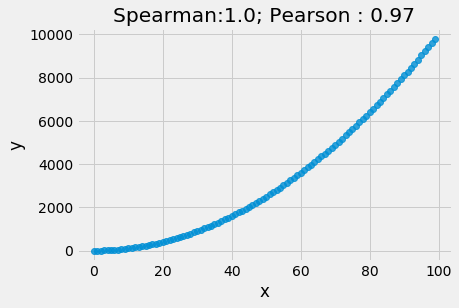

In [63]:
x =np.array(range(100))
y = x**2
plot_corrs(x,y)

Spearman 상관 관계는 종종 목표 또는 교육 기간과 같은 서수 변수에 대해 더 나은 것으로 간주됩니다. 실제 세계에서 대부분의 관계는 선형 적이 지 않으며 피어슨 상관 관계는 두 변수가 얼마나 관련되어 있는지에 대한 근사치 일 수 있지만 정확하지 않으며 최상의 비교 방법은 아닙니다.


In [64]:
train_heads= heads.loc[heads['Target'].notnull(),:].copy()

pcorrs = pd.DataFrame(train_heads.corr()['Target'].sort_values()).rename(columns = {'Target':'pcorr'}).reset_index()
pcorrs = pcorrs.rename(columns ={'index':'feature'})

print('Most negatively correlated variable:')
print(pcorrs.head())
print('\nMost [positively] correlated variable:')
print(pcorrs.dropna().tail())

Most negatively correlated variable:
        feature     pcorr
0       warning -0.301791
1     hogar_nin -0.266309
2          r4t1 -0.260917
3  overcrowding -0.234954
4         eviv1 -0.217908

Most [positively] correlated variable:
               feature     pcorr
97   phones-per-capita  0.299026
98               floor  0.307605
99    walls+roof+floor  0.332446
100           meaneduc  0.333652
101             Target  1.000000


또는 음의 상관 관계는 변수가 증가함에 따라 목표가 감소하여 빈곤 심각도가 증가 함을 나타냅니다. 따라서 경고가 증가함에 따라 빈곤층도 증가합니다. 이는 주택에 대한 잠재적 나쁜 징후를 나타 내기위한 것이기 때문입니다. hogar_nin은 가족 내 0-19 세 아동의 수이며, 이는 또한 의미가 있습니다. 또는 사회 경제적 지위가 낮은 가정은 그 중 하나가 성공할 수 있기를 희망하는 자녀가 더 많습니다. 설명이 무엇이든, 가족 규모와 빈곤 사이에는 실제 연관성이 있습니다

반면, 양의 상관 관계에서 값이 높을수록 빈곤 심각도가 감소 함을 나타내는 Target 값이 높아짐을 의미합니다. 가장 관련성이 높은 가구 수준 변수는 가구 내 성인의 평균 교육 수준 인 평균 교육입니다. 교육과 빈곤 사이의 이러한 관계는 직관적으로 의미가 있습니다. 교육 수준이 높을수록 일반적으로 빈곤 수준이 낮습니다. 우리는 어떤 원인이 무엇인지 반드시 알 필요는 없지만 같은 방향으로 움직이는 경향이 있다는 것을 알고 있습니다.

상관 관계 값에 대한 일반적인 지침은 다음과 같지만 요청한 사람에 따라 달라집니다 (t의 출처

In [65]:
import warnings
warnings.filterwarnings('ignore',category = RuntimeWarning)
feats = []
scorr = []
pvalues = []

##각 컬럼 반복
for c in heads:
    ## 수치형 변수만 
    if heads[c].dtype !='object':
        feats.append(c)
        
        #스피어만 상관계수 게싼
        scorr.append(spearmanr(train_heads[c], train_heads['Target']).correlation)
        pvalues.append(spearmanr(train_heads[c], train_heads['Target']).pvalue)
        
scorrs = pd.DataFrame({'feature':feats,'scorr':scorr,'pavlue':pvalues}).sort_values('scorr')

In [66]:
scorrs.head()

,feature,scorr,pavlue
97,warning,-0.307326,4.682829e-66
68,dependency,-0.281516,2.792620e-55
85,hogar_nin,-0.236225,5.567218e-39
80,r4t1,-0.219226,1.112230e-33
49,eviv1,-0.217803,2.952571e-33


Spearman 상관 계수 계산에는 관계의 유의 수준을 나타내는 pvalue도 제공됩니다. 0.05 미만의 모든 pvalue는 일반적으로 유의 한 것으로 간주되지만, 다중 비교를 수행하기 때문에 p- 값을 Bonferroni 보정이라는 프로세스 인 비교 수로 나눕니다.


In [67]:
print('Most negative Spearman correlations:')
print(scorrs.head())
print('\nMost positive Spearman correlations:')
print(scorrs.dropna().tail())

Most negative Spearman correlations:
       feature     scorr        pavlue
97     warning -0.307326  4.682829e-66
68  dependency -0.281516  2.792620e-55
85   hogar_nin -0.236225  5.567218e-39
80        r4t1 -0.219226  1.112230e-33
49       eviv1 -0.217803  2.952571e-33

Most positive Spearman correlations:
              feature     scorr        pavlue
23          cielorazo  0.300996  2.611808e-63
95              floor  0.309638  4.466091e-67
99  phones-per-capita  0.337377  4.760104e-80
96   walls+roof+floor  0.338791  9.539346e-81
0              Target  1.000000  0.000000e+00


In [68]:
corrs = pcorrs.merge(scorrs, on = 'feature')
corrs['diff'] = corrs['pcorr']-corrs['scorr']

corrs.sort_values('diff').head()

,feature,pcorr,scorr,pavlue,diff
77,rooms-per-capita,0.152185,0.223303,6.521453e-35,-0.071119
85,v18q1,0.197493,0.244200,1.282664e-41,-0.046708
87,tablets-per-capita,0.204638,0.248642,3.951568e-43,-0.044004
2,r4t1,-0.260917,-0.219226,1.112230e-33,-0.041691
97,phones-per-capita,0.299026,0.337377,4.760104e-80,-0.038351


In [69]:
corrs.sort_values('diff').dropna().tail()

,feature,pcorr,scorr,pavlue,diff
57,techozinc,0.014357,0.003404,8.528369e-01,0.010954
49,hogar_mayor,-0.025173,-0.041722,2.290994e-02,0.016549
88,edjefe,0.235687,0.214736,2.367521e-32,0.020951
66,edjefa,0.052310,0.005114,7.804715e-01,0.047197
17,dependency,-0.126465,-0.281516,2.792620e-55,0.155051


Text(0.5, 1, 'Target vs Dependency')

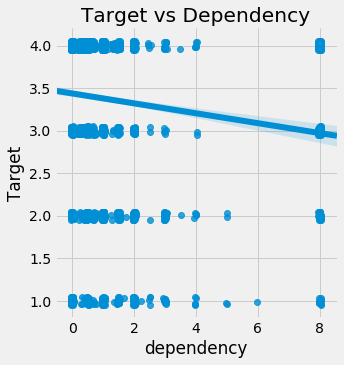

In [70]:
sns.lmplot('dependency','Target',fit_reg = True, data =train_heads, x_jitter = 0.05,y_jitter=0.05)
plt.title('Target vs Dependency')

관계를보기는 어렵지만 약간 부정적입니다. 종속성이 증가하면 대상 값이 감소합니다. 의존성은 독립된 개인의 수를 비의존적인 수로 나눈 값입니다. 우리가이 가치를 높이면 빈곤 심각도는 증가하는 경향이 있습니다. 더 많은 부양 가족 (일반적으로 일을하지 않는)은 빈곤층이 비 가족 가족의지지를 받아야하기 때문에 더 높은 수준의 빈곤으로 이어집니다.

Text(0.5, 1, 'Target vs Rooms Per Capita')

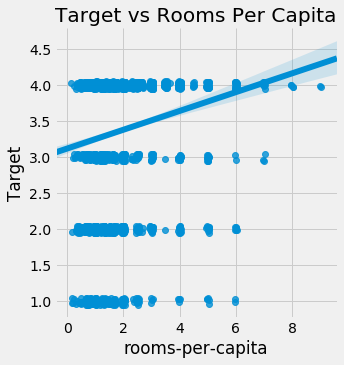

In [71]:
sns.lmplot('rooms-per-capita','Target',fit_reg = True, data = train_heads, x_jitter = 0.05, y_jitter = 0.05)
plt.title('Target vs Rooms Per Capita')

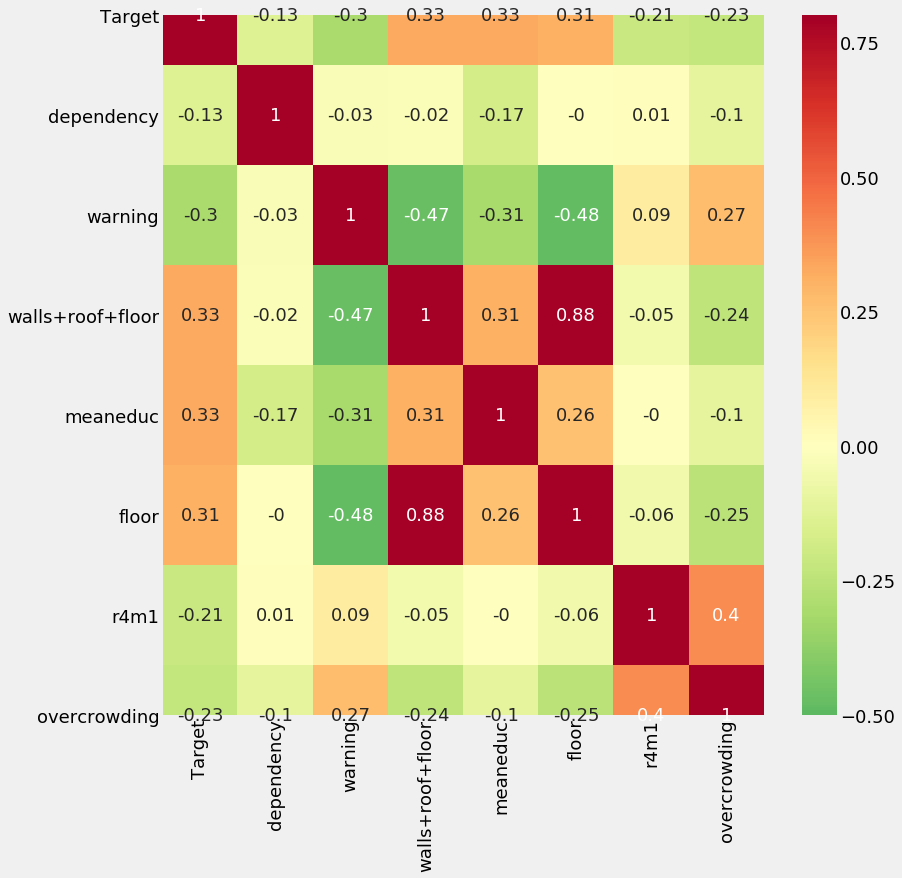

In [72]:
variables = ['Target','dependency','warning','walls+roof+floor','meaneduc','floor','r4m1','overcrowding']

##상관계수 계산
corr_mat = train_heads[variables].corr().round(2)

##히트맵
plt.rcParams['font.size'] = 18
plt.figure(figsize = (12,12))
sns.heatmap(corr_mat,vmin =-0.5,vmax=0.8,center =0, cmap = plt.cm.RdYlGn_r,annot =True)


이 그림은 대상과 약한 상관 관계가있는 여러 변수가 있음을 보여줍니다. 공선 성으로 인해 문제를 일으킬 수있는 일부 변수 (예 : 바닥 및 벽 + 지붕 + 바닥) 사이에는 높은 상관 관계가 있습니다.

## Features plot
세대 수준 데이터의 최종 탐색을 위해 대상과 가장 관련성이 높은 변수를 그릴 수 있습니다. 위 삼각형의 산점도, 대각선의 커널 밀도 추정 (kde) 도표, 아래쪽 삼각형의 2D KDE 도표

Text(0.5, 1.05, 'Feature Plots Colored By Target')

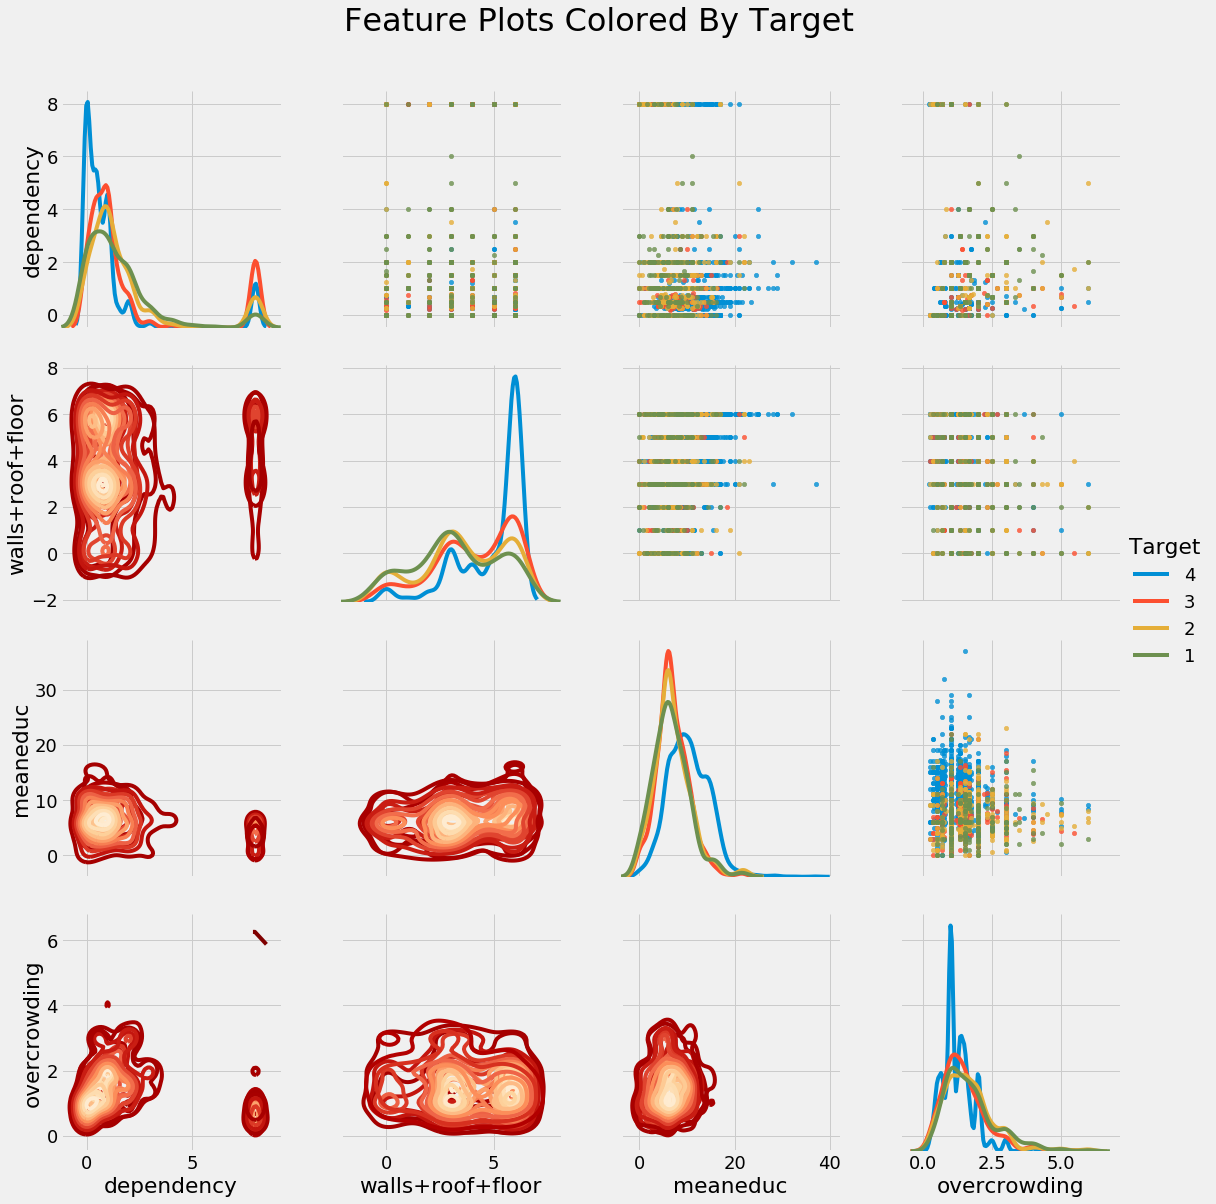

In [73]:
#Featuers plot 
import warnings 
warnings.filterwarnings('ignore') # 경고 무시 

#
plot_data = train_heads[['Target','dependency','walls+roof+floor',
                        'meaneduc','overcrowding']]
grid = sns.PairGrid(data = plot_data, size =4, diag_sharey =False, hue = 'Target', hue_order = [4,3,2,1],
                   vars = [x for x in list(plot_data.columns) if x !='Target'])

grid.map_upper(plt.scatter, alpha = 0.8, s= 20)

grid.map_diag(sns.kdeplot)

grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r)
grid = grid.add_legend()
plt.suptitle('Feature Plots Colored By Target', size = 32, y= 1.05)

지금은 가계 변수의 기능 공학을 그대로 두겠습니다. 나중에 모델 성능에 만족하지 않으면이 단계로 돌아갈 수 있습니다.

## individual Level Variables
개별 레벨 변수에는 부울 (True 또는 False의 경우 1 또는 0)과 서수 (의미있는 순서를 갖는 개별 값)의 두 가지 유형이 있습니다.

In [74]:
ind = data[id_+ind_bool + ind_ordered]
ind.shape

(33413, 40)

## Redundant individual 
가계 수준 변수와 동일한 프로세스를 수행하여 중복 개별 변수를 식별 할 수 있습니다. 0.95보다 큰 상관 계수의 절대 크기를 갖는 모든 변수에 중점을 둘 것입니다.

In [75]:
#
corr_matrix = ind.corr()

# 
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k =1).astype(np.bool))

to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]
to_drop

['female']

이것은 단순히 남자의 반대입니다! 수컷 깃발을 제거 할 수 있습니다.

In [76]:
ind = ind.drop(columns = 'male')

## Creating Ordinal Variables
가정 수준 데이터와 마찬가지로 기존 열을 서수 변수에 매핑 할 수 있습니다. 여기서 우리는 개인이 instlevel1에서 교육 수준 없음 : instlevel9 : 대학원 교육 수준을 나타내는 instlevel_ 변수에 중점을 둘 것입니다.

서수 변수를 만들기 위해 각 개인에 대해 0이 아닌 열을 간단히 찾습니다. 교육은 순서가 고유하므로 (높을수록 좋음) 문제 변수에서 순서 변수로의 변환은 의미가 있습니다.

In [77]:
ind[[c for c in ind if c.startswith('instl')]].head()

,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0


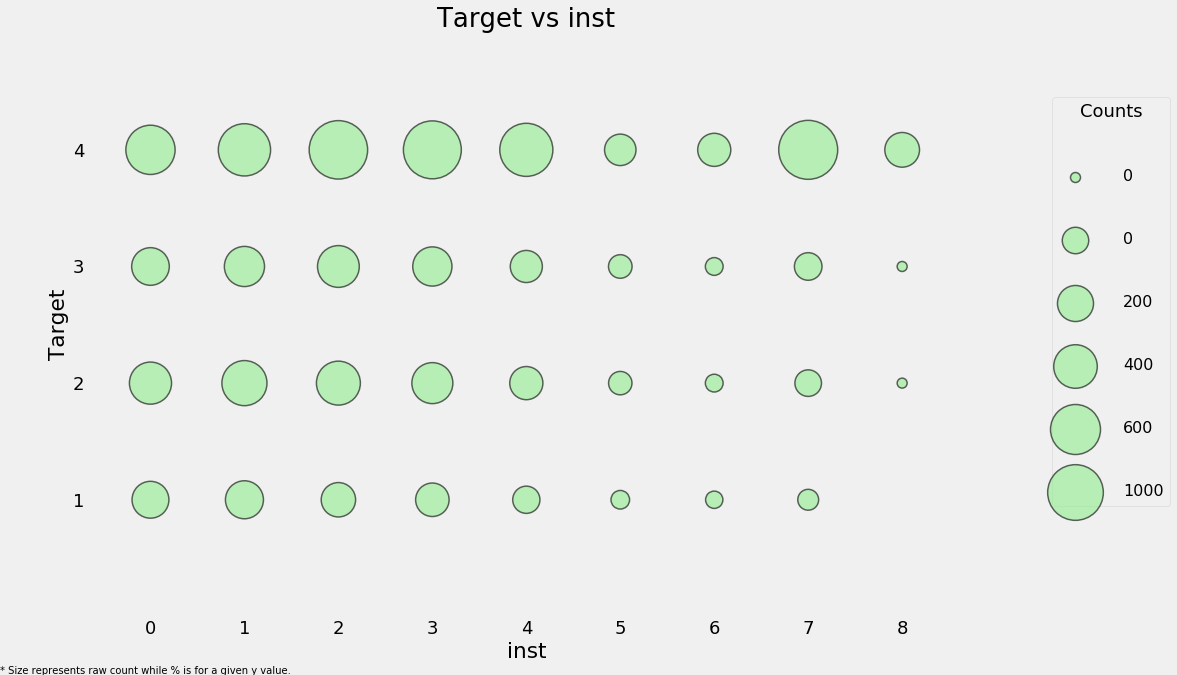

In [78]:
ind['inst'] = np.argmax(np.array(ind[[ c for c in ind if c.startswith('instl')]]), axis =1)
plot_categoricals('inst','Target', ind, annotate = False)

교육 수준이 높을수록 극심한 빈곤 수준에 해당하는 것으로 보입니다. 우리는 이것이 개인 수준에 있다는 것을 명심해야하며 결국에는이 데이터를 가정 수준에서 집계해야합니다

Text(0.5, 1.0, 'Education Distribution by Target')

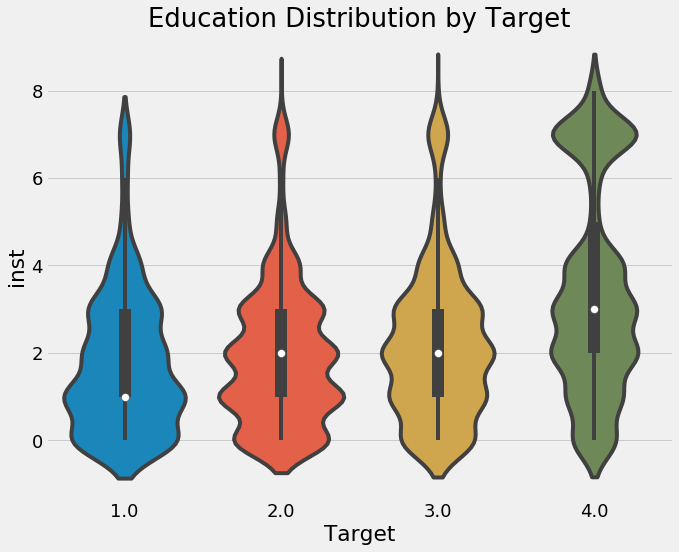

In [79]:
plt.figure(figsize = (10,8))
sns.violinplot(x = 'Target',y = 'inst',data =ind)
plt.title('Education Distribution by Target')

In [80]:
## 교육 변수 제거
## ind = ind.drop(columns = [c for c in ind if c.startwith('instlevel')])
ind.shape

(33413, 40)

## Feature Construction
기존 데이터를 사용하여 몇 가지 기능을 만들 수 있습니다. 예를 들어, 학교 연수를 연령별로 나눌 수 있습니다.


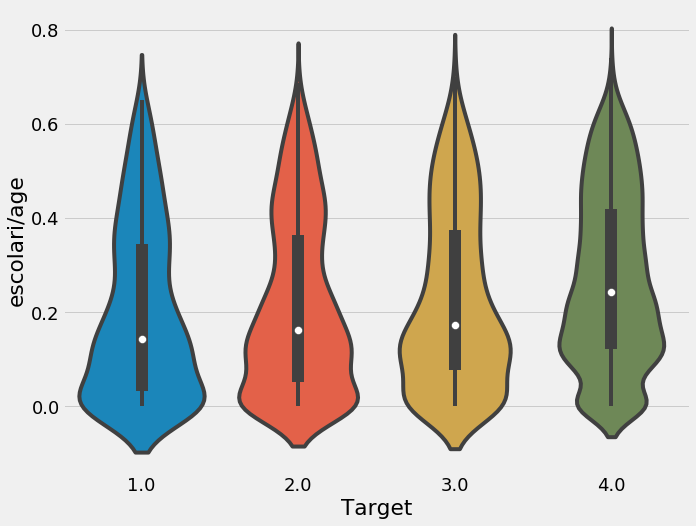

In [81]:
ind['escolari/age'] = ind['escolari'] / ind['age']

plt.figure(figsize = (10,8))
sns.violinplot('Target','escolari/age',data = ind)

우리는 또한 새로운 변수 inst를 취하여 이것을 연령으로 나눌 수 있습니다. 우리가 기술로 명명 할 마지막 변수는 태블릿과 휴대폰의 조합을 나타냅니다.


In [82]:
ind['inst/age'] = ind['inst'] / ind['age']
ind['tech'] = ind['v18q']+ind['mobilephone']
ind['tech'].describe()

count    33413.000000
mean         1.214886
std          0.462567
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: tech, dtype: float64

## Feature Enginnering through Aggregations
개인 데이터를 가구 데이터에 통합하려면 각 가구에 대해 데이터를 집계해야합니다. 가장 간단한 방법은 가족 id idhogar를 그룹화 한 다음 데이터를 수집하는 것입니다. 순서 변수 또는 연속 변수의 집계에는 6 개를 사용할 수 있습니다. 그 중 5 개는 팬더에 내장되어 있고 그 중 하나는 range_를 정의합니다. 부울 집계는 동일 할 수 있지만 이로 인해 많은 중복 열이 만들어져 삭제해야합니다. 이 경우 동일한 집계를 사용한 다음 중복 열을 다시 삭제합니다.

In [83]:
range_ = lambda x : x.max() - x.min()
range_.__name__ = 'range_'

# 그룹화 통계량 계산
ind_agg = ind.drop(columns = 'Target').groupby('idhogar').agg(['min','max','sum','count','std',range_])
ind_agg.head()

## 

v18q                           dis                ...  inst/age  \
           min max sum count  std range_ min max sum count  ...       sum   
idhogar                                                     ...             
000a08204    1   1   3     3  0.0      0   0   0   0     3  ...  0.483333   
000bce7c4    0   0   0     2  0.0      0   0   1   1     2  ...  0.016667   
001845fb0    0   0   0     4  0.0      0   0   0   0     4  ...  0.511959   
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  ...  0.184211   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  ...  0.213768   

                                    tech                            
          count       std    range_  min max sum count  std range_  
idhogar                                                             
000a08204     3  0.139775  0.250000    2   2   6     3  0.0      0  
000bce7c4     2  0.011785  0.016667    1   1   2     2  0.0      0  
001845fb0     4  0.060123  0.128205    1   1   4     4  0.0      0  
001ff74ca     1       NaN  0.000000    2   2   4     2  0.0      0  
003123ec2     4  0.064636  0.130435    1   1   4     4  0.0      0  

[5 rows x 234 columns]

한 줄만 사용하면 30 개의 기능에서 180 개로 이동합니다. 다음으로 열 이름을 변경하여 추적하기가 더 쉽습니다.


In [84]:
# 변수명 재정의
new_col = []
for c in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{c}-{stat}')
ind_agg.columns = new_col
ind_agg.head()

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-std,v18q-range_,dis-min,dis-max,dis-sum,dis-count,...,inst/age-sum,inst/age-count,inst/age-std,inst/age-range_,tech-min,tech-max,tech-sum,tech-count,tech-std,tech-range_
idhogar,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,...,0.483333,3,0.139775,0.250000,2,2,6,3,0.0,0
000bce7c4,0,0,0,2,0.0,0,0,1,1,2,...,0.016667,2,0.011785,0.016667,1,1,2,2,0.0,0
001845fb0,0,0,0,4,0.0,0,0,0,0,4,...,0.511959,4,0.060123,0.128205,1,1,4,4,0.0,0
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,...,0.184211,1,NaN,0.000000,2,2,4,2,0.0,0
003123ec2,0,0,0,4,0.0,0,0,0,0,4,...,0.213768,4,0.064636,0.130435,1,1,4,4,0.0,0


In [85]:
ind_agg.iloc[:,[0,1,2,3,6,7,8,9]].head()

,v18q-min,v18q-max,v18q-sum,v18q-count,dis-min,dis-max,dis-sum,dis-count
idhogar,,,,,,,,
000a08204,1,1,3,3,0,0,0,3
000bce7c4,0,0,0,2,0,1,1,2
001845fb0,0,0,0,4,0,0,0,4
001ff74ca,1,1,2,2,0,0,0,2
003123ec2,0,0,0,4,0,0,0,4


In [86]:
## Feature Selection 
corr_matrix = ind_agg.corr()

#
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k =1).astype(np.bool))

#
to_drop =[column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print(f'There are {len(to_drop)} correlated columns to remove.')

There are 111 correlated columns to remove.


열을 삭제 한 다음 헤드 데이터와 병합하여 최종 데이터 프레임을 만듭니다.


In [87]:
ind_agg = ind_agg.drop(columns = to_drop)
idn_feats = list(ind_agg.columns)

# household id 결합
final = heads.merge(ind_agg, on = 'idhogar', how = 'left')


print('Final features shape:', final.shape)

Final features shape: (10307, 228)


In [88]:
final.head()

,Id,idhogar,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,...,escolari/age-sum,escolari/age-std,escolari/age-range_,inst/age-max,inst/age-std,inst/age-range_,tech-min,tech-sum,tech-std,tech-range_
0,ID_279628684,21eb7fcc1,4.0,0,0,1,1,1,0,0,...,0.232558,NaN,0.000000,0.069767,NaN,0.000000,1,1,NaN,0
1,ID_f29eb3ddd,0e5d7a658,4.0,0,0,1,1,0,0,0,...,0.179104,NaN,0.000000,0.104478,NaN,0.000000,2,2,NaN,0
2,ID_68de51c94,2c7317ea8,4.0,0,0,1,1,0,0,0,...,0.119565,NaN,0.000000,0.043478,NaN,0.000000,0,0,NaN,0
3,ID_ec05b1a7b,2b58d945f,4.0,0,0,1,1,1,0,0,...,1.366183,0.126943,0.279412,0.176471,0.033010,0.071207,2,8,0.0,0
4,ID_1284f8aad,d6dae86b7,4.0,1,0,1,1,1,0,0,...,0.965584,0.168946,0.392857,0.142857,0.060063,0.142857,1,4,0.0,0


In [89]:
## Final Data Exploration
corrs = final.corr()['Target']

In [90]:
corrs.sort_values().head()

warning          -0.301791
instlevel2-sum   -0.297868
instlevel1-sum   -0.271204
hogar_nin        -0.266309
r4t1             -0.260917
Name: Target, dtype: float64

In [91]:
corrs.sort_values().dropna().tail()

walls+roof+floor    0.332446
meaneduc            0.333652
inst-max            0.368229
escolari-max        0.373091
Target              1.000000
Name: Target, dtype: float64

우리가 만든 변수 중 일부가 목표와 밀접한 상관 관계가 있음을 알 수 있습니다. 이러한 변수가 실제로 유용한 지 여부는 모델링 단계에서 결정됩니다.


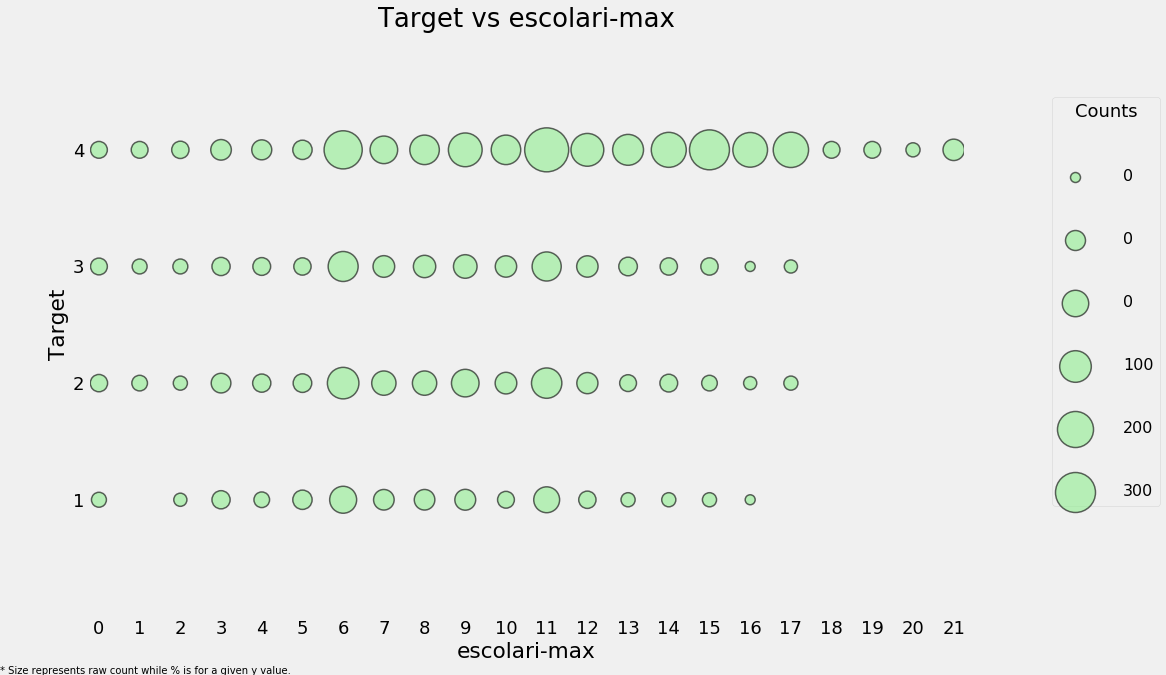

In [92]:
plot_categoricals('escolari-max','Target',final,annotate = False)

Text(0.5, 1.0, 'Max Schooling b Target')

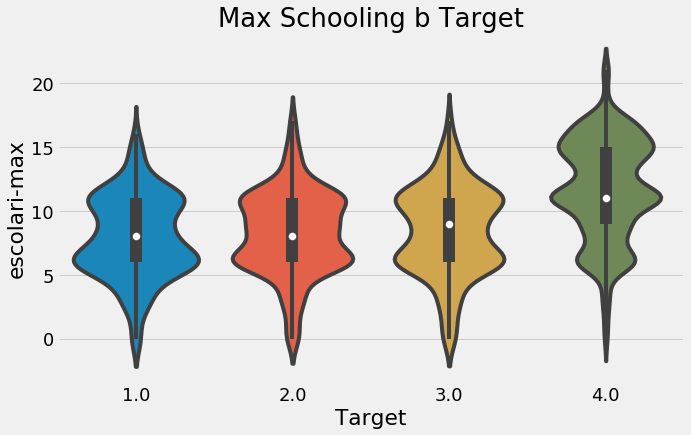

In [93]:
plt.figure(figsize = (10,6))
sns.violinplot(x= 'Target', y= 'escolari-max',data = final)
plt.title('Max Schooling b Target')

Text(0.5, 1.0, 'Max Schooling by Target')

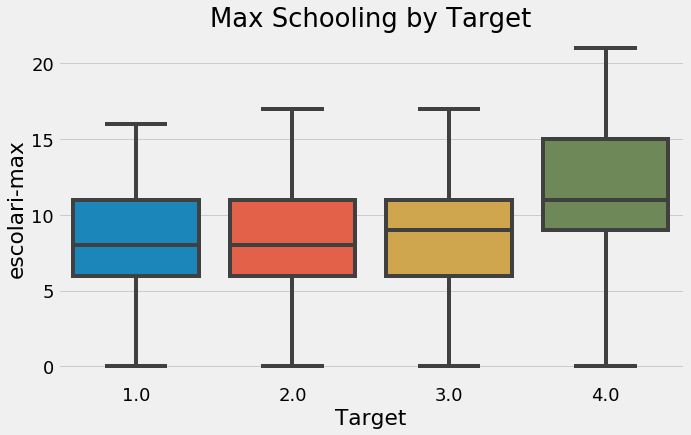

In [94]:
plt.figure(figsize = (10,6))
sns.boxplot(x = 'Target', y= 'escolari-max', data =final)
plt.title('Max Schooling by Target')

Text(0.5, 1.0, 'Average Schooling by Target')

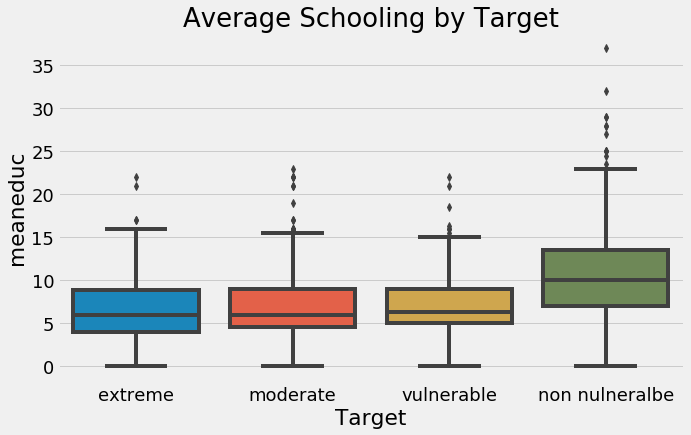

In [95]:
plt.figure(figsize = (10,6))
sns.boxplot(x = 'Target',y = 'meaneduc', data = final)
plt.xticks([0,1,2,3], poverty_mapping.values())
plt.title('Average Schooling by Target')

Text(0.5, 1.0, 'Overcrowding by Target')

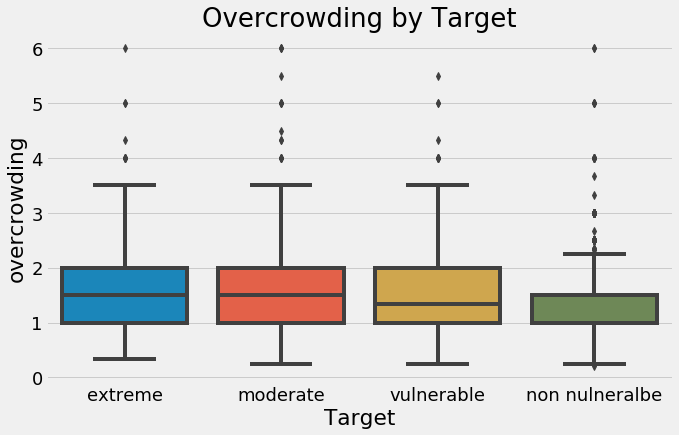

In [96]:
plt.figure(figsize = (10,6))
sns.boxplot(x = 'Target', y = 'overcrowding',data =final)
plt.xticks([0,1,2,3], poverty_mapping.values())
plt.title('Overcrowding by Target')


유용 할 수있는 다른 기능 중 하나는 세대주의 성별입니다. 데이터를 집계 했으므로 개인 수준 데이터로 돌아가서 집주인의 성별을 찾아야합니다.


In [97]:
head_gender = ind.loc[ind['parentesco1'] ==1, ['idhogar','female']]
final = final.merge(head_gender, on ='idhogar',how = 'left').rename(columns = {'female':'female_head'})

In [98]:
final.groupby('female_head')['Target'].value_counts(normalize = True)

female_head  Target
0            4.0       0.682873
             2.0       0.136464
             3.0       0.123204
             1.0       0.057459
1            4.0       0.617369
             2.0       0.167670
             3.0       0.113500
             1.0       0.101462
Name: Target, dtype: float64

머리가 여성 인 가정은 가난이 심각 할 가능성이 약간 높습니다.


Text(0.5, 1.0, 'Target by Female Head of Household')

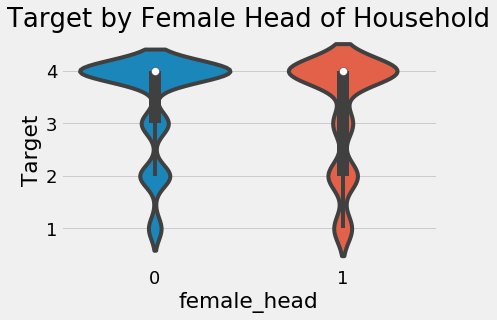

In [99]:
sns.violinplot(x = 'female_head', y= 'Target', data = final)
plt.title('Target by Female Head of Household')

또한 가정에 여성 수장이 있는지 여부에 따라 평균 교육의 차이를 확인할 수 있습니다.


Text(0.5, 1.0, 'Average Education by Target and Female Head of Household')

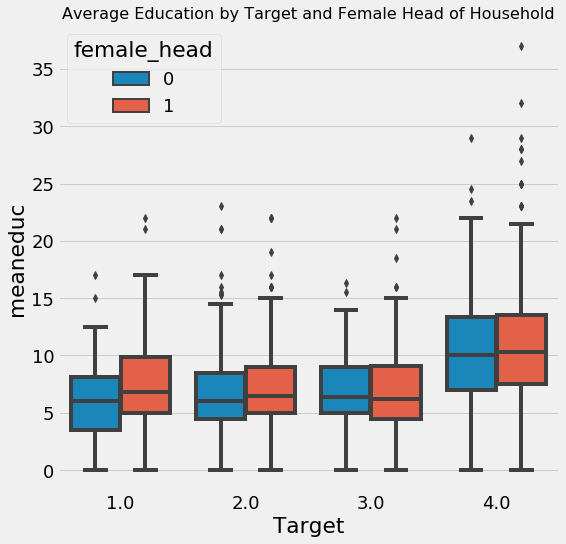

In [100]:
plt.figure(figsize= (8,8))
sns.boxplot(x = 'Target', y= 'meaneduc', hue = 'female_head',data = final)
plt.title('Average Education by Target and Female Head of Household', size = 16)

목표의 모든 가치 에서처럼, 여성의 머리를 가진 가정은 더 높은 수준의 교육을받습니다. 그러나 우리는 전체적으로 여성의 머리를 가진 가구가 가난을 겪을 가능성이 더 높다는 것을 알았습니다.


In [101]:
final.groupby('female_head')['meaneduc'].agg(['mean','count'])

,mean,count
female_head,,
0,8.968025,6384
1,9.237013,3903


전반적으로 여성의 머리를 가진 가정의 평균 교육은 남성의 머리를 가진 가정보다 약간 높습니다. 나는 이것을 무엇으로 만들어야할지 잘 모르겠지만 그것은 나에게 옳아 보인다.


## Machine Learning Modeling
기능 엔지니어링 / 시공이 완료되면 기계 학습을 시작할 수 있습니다! 모든 데이터 (훈련 및 테스트)는 각 가정에 대해 집계되므로 모델에서 직접 사용할 수 있습니다. 먼저 모델링 과정을 보여주기 위해 Scikit-Learn에서 유능한 랜덤 포레스트 분류기를 사용합니다. 이것은 아마도 우리를 순위표의 정상에 오르지 못할 것이지만, 그것은 우리가 기준을 정할 수있게 해줄 것입니다. 나중에 우리는 강력한 Gradient Boosting Machine을 포함한 여러 가지 다른 모델을 시도 할 것입니다.


모델을 평가하기 위해 훈련 데이터에 10 배 교차 검증을 사용합니다. 이것은 본질적으로 서로 다른 훈련 데이터를 사용하여 모델을 10 회 훈련하고 테스트합니다. 10 배 교차 검증은 테스트 세트에서 모델의 성능을 추정하는 효과적인 방법입니다. 우리는 교차 검증의 평균 성능과 표준 편차를보고 폴드간에 점수가 얼마나 변하는 지 확인하려고합니다. F1 Macro 측정 값을 사용하여 성능을 평가합니다.


In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

#
score = make_scorer(f1_score, greater_is_better = True, average ='macro')

In [103]:
## 
train_labels = np.array(list(final[final['Target'].notnull()]['Target'].astype(np.uint8)))

## 훈련 셋 추출
train_set = final[final['Target'].notnull()].drop(columns = ['Id','idhogar','Target'])
test_set = final[final['Target'].isnull()].drop(columns = ['Id','idhogar','Target'])

#
submission_base = test[['Id','idhogar']].copy()

서로 다른 모델을 비교할 예정이므로 기능의 스케일을 조정하려고합니다 (각 열의 범위를 0과 1 사이로 제한). 많은 앙상블 모델에는 이것이 필요하지 않지만 KNearest Neighbors 또는 Support Vector Machine과 같은 거리 측정법에 의존하는 모델을 사용하는 경우 기능 스케일링이 절대적으로 필요합니다. 다른 모델을 비교할 때는 항상 기능을 확장하는 것이 가장 안전합니다. 또한 피쳐의 중앙값으로 결 측값을 대치합니다.

결 측값을 대치하고 한 단계로 기능을 확장하기 위해 파이프 라인을 만들 수 있습니다. 이는 교육 데이터에 적합하며 교육 및 테스트 데이터를 변환하는 데 사용됩니다.

In [104]:
features = list(train_set.columns)
pipeline = Pipeline([('imputer',Imputer(strategy = 'median')),
                    ('scaler', MinMaxScaler())])

## 
train_set = pipeline.fit_transform(train_set)
test_set = pipeline.fit_transform(test_set)

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


데이터에 결 측값이 없으며 0과 1 사이로 조정됩니다. 이는 모든 Scikit-Learn 모델에서 직접 사용할 수 있음을 의미합니다.


In [105]:
model = RandomForestClassifier(n_estimators = 100, random_state = 10, n_jobs =-1)

## 
cv_score = cross_val_score(model, train_set, train_labels, cv = 10, scoring =score)
print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(),4)} with std = {round(cv_score.std(),4)}')

10 Fold Cross Validation F1 Score = 0.3439 with std = 0.0313


그 점수는 크지 않지만 기준선이 될 것이며 개선 할 여지가 충분합니다!


## Feature Importances
트리 기반 모델을 사용하면 모델에서 기능의 유용성에 대한 상대적 순위를 보여주는 기능 중요도를 볼 수 있습니다. 이는 분할에 변수를 사용한 노드에서 불순물 감소의 합계를 나타내지 만 절대 값에 많은주의를 기울일 필요는 없습니다. 대신 상대 점수에 중점을 둘 것입니다.

기능의 중요성을 보려면 전체 교육 세트에서 모델을 교육해야합니다. 교차 유효성 검사는 기능 중요도를 반환하지 않습니다

In [106]:
model.fit(train_set,train_labels)

## 변수 중요도 
feature_importances = pd.DataFrame({'feature':features,'importance':model.feature_importances_})
feature_importances.head()

,feature,importance
0,hacdor,0.000643
1,hacapo,0.000283
2,v14a,0.000460
3,refrig,0.001798
4,paredblolad,0.006024


아래는 기능의 중요도를 나타내는 데 사용할 간단한 기능입니다. 이 기능을 많이 사용하고 종종 스크립트간에 복사하여 붙여 넣습니다. 문서가 이해되기를 바랍니다!


In [107]:
def plot_feature_importances(df, n = 10, threshold = None):
    plt.style.use('fivethirtyeight')
    
    ## 중요변수 순으로 정렬
    df = df.sort_values('importance',ascending = False).reset_index(drop =True)
    
    ## 정규화된 누적 변수중요도
    
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # 변수 중요도 막대 그래프 
    df.loc[:n,:].plot.barh(y = 'importance_normalized',
                          x= 'feature',color = 'darkgreen',
                          edgecolor = 'k', figsize = (12,8),
                          legend = False, linewidth =2)
    plt.xlabel('Normalized Importance', size = 18)
    plt.ylabel('')
    plt.title(f'{n} Most Importance Features', size =18)
    plt.gca().invert_yaxis()
    
    if threshold:
        ## 누적 그래프
        plt.figure(figsize = (8,6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16)
        plt.ylabel('Cumulative Importance', size = 16)
        plt.title('Cumlative Feature Importance', size = 18)
        
        #
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        #
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--',colors = 'red')
        plt.show()
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index +1,100*threshold))
    
        return df

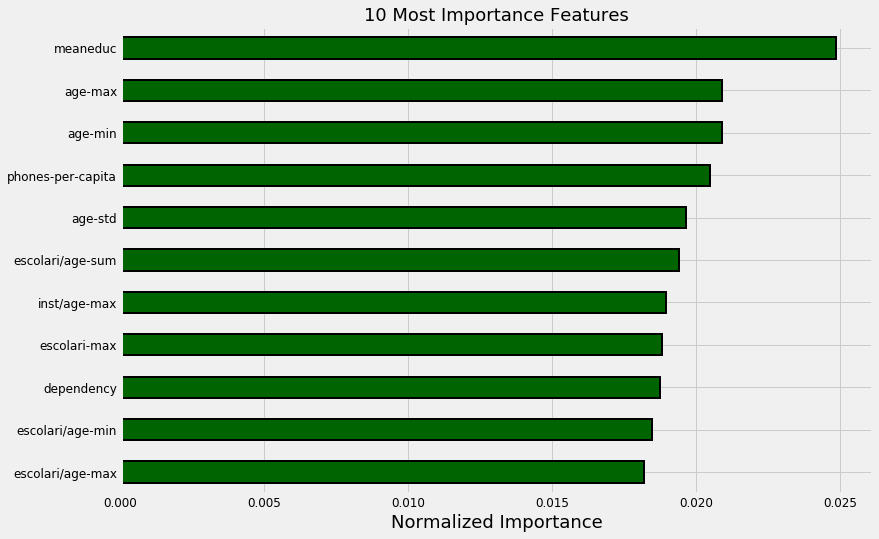

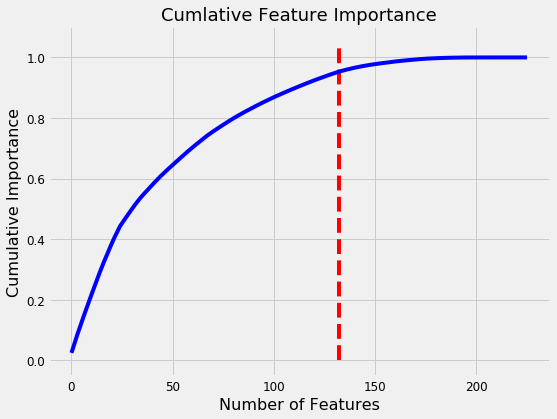

132 features required for 95% of cumulative importance.


In [108]:
norm_fi = plot_feature_importances(feature_importances, threshold = 0.95)

교육이 최고입니다! 가장 중요한 변수는 가구의 평균 교육 량에 이어 가구 내 모든 사람의 최대 교육이 뒤 따릅니다. 이러한 변수가 서로 밀접하게 관련되어 있다는 사실이 의심 스럽습니다 (공 선형). 데이터에서 변수 중 하나를 제거 할 수 있습니다. 가장 중요한 다른 기능은 우리가 만든 변수와 데이터에 이미 존재하는 변수의 조합입니다.


중요도의 90 %를 차지하기 위해 ~ 180 개의 기능 중 106 개만 필요하다는 점이 흥미 롭습니다. 이는 일부 기능을 제거 할 수 있음을 알려줍니다. 그러나 기능의 중요성은 기능의 어느 방향이 중요한지를 알려주지 않습니다 (예를 들어, 교육이 더 빈곤한지 더 심각한 빈곤으로 이어지는 지 알 수 없음).


In [109]:
def kde_target(df, variable):
    
    colors = {1: 'red', 2:'orange',3:'blue',4:'green'}
    
    plt.figure(figsize = (12,8))
    
    df = df[df['Target'].notnull()]
    
    for level in df['Target'].unique():
        subset = df[df['Target'] == level].copy()
        sns.kdeplot(subset[variable].dropna(),
                   label = f'Poverty Level: {level}',
                    color = colors[int(subset['Target'].unique())])
    plt.xlabel(variable)
    plt.ylabel('Density')
    plt.title('{} Distribution'.format(variable.capitalize()))

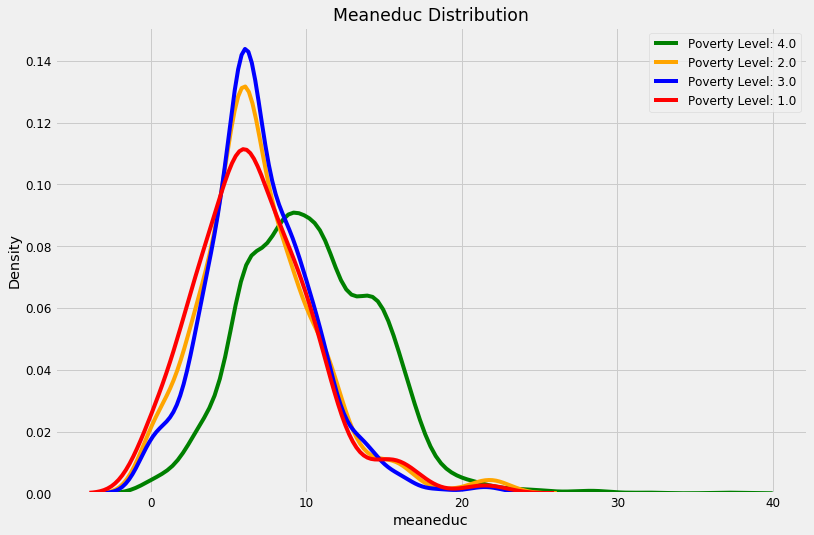

In [110]:
kde_target(final, 'meaneduc')

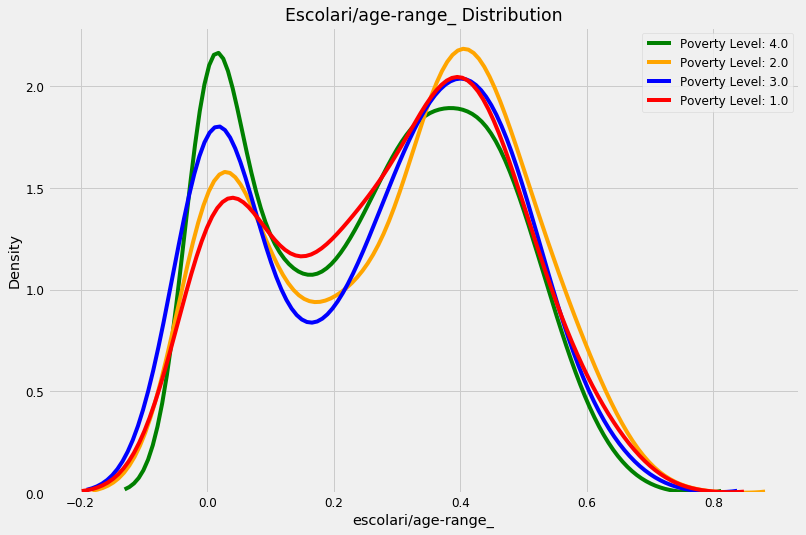

In [111]:
kde_target(final,'escolari/age-range_')

## Model Selection

이제 다양한 기능을 갖추 었으므로 이제 모델링에 들어가야합니다. 우리는 이미 하나의 기본 모델 인 Random Forest Classifier를 사용해 보았습니다. Random Forest Classifier는 최고의 매크로 F1을 0.35로 전달했습니다. 그러나 머신 러닝에서는 특정 데이터 세트에 가장 적합한 모델을 미리 알 수있는 방법이 없습니다. 다음 그림은 가우시안 Naive Bayes도 그래디언트 부스팅 머신보다 성능이 우수한 문제가 있음을 보여줍니다. 이 문서는 Randal Olson의 훌륭한 논문에서 나온 것으로, 머신 러닝의 많은 점에 대해 논의합니다.

이 그림에서 알 수있는 것은 최적의 모델을 찾기 위해 여러 가지 다른 모델을 시도해야한다는 것입니다. 대부분의 사람들은 결국 그라디언트 부스팅 머신에 정착하고 우리는 그것을 시도 할 것이지만, 지금 우리는 다른 옵션 중 일부를 살펴볼 것입니다. Scikit-Learn 문서를 보면 말 그대로 수십 개의 (다수의) 멀티 클래스 머신 러닝 모델이 있습니다. 모든 것을 시도 할 필요는 없지만 옵션에서 샘플링해야합니다.

우리가하고 싶은 것은 모델을 평가할 수있는 함수를 작성하는 것입니다. 우리가 이미 대부분의 코드를 작성했기 때문에 이것은 매우 간단합니다. Random Forest Classifier 외에도 8 개의 다른 Scikit-Learn 모델을 시도해 봅니다. 운 좋게도이 데이터 세트는 비교적 작으며 모델을 신속하게 반복 할 수 있습니다. 결과를 보유 할 데이터 프레임을 만들고 함수는 각 모델의 데이터 프레임에 행을 추가합니다.

In [112]:
# model 라이브러리
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier



In [113]:

import warnings
from sklearn.exceptions import ConvergenceWarning

#
warnings.filterwarnings('ignore',category = ConvergenceWarning)
warnings.filterwarnings('ignore',category = DeprecationWarning)
warnings.filterwarnings('ignore',category = UserWarning)

#결과 데이터 프레임
model_results = pd.DataFrame(columns = ['model','cv_mean','cv_std'])

def cv_model(train, train_labels, model, name, model_results = None):
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring=score, n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model':name,
                                                          'cv_mean':cv_scores.mean(),
                                                          'cv_std':cv_scores.std()},
                                                         index = [0]),
                                            ignore_index = True)
        return model_results

In [114]:
model_results = cv_model(train_set, train_labels, LinearSVC(),
                        'LSVC',model_results)

10 Fold CV Score: 0.28346 with std: 0.04484


그 점수는 크지 않지만 기준선이 될 것이며 개선 할 여지가 충분합니다!


In [115]:
model_resutls = cv_model(train_set,train_labels,GaussianNB(),'GNB',model_results)

10 Fold CV Score: 0.17935 with std: 0.03867


그 성능은 매우 열악합니다. Gaussian Naive Bayes 방법을 다시 방문해야한다고 생각하지 않습니다 (그라디언트 부스팅 머신보다 성능이 우수 할 수있는 문제가 있음).


In [117]:
model_results = cv_model(train_set, train_labels,
                        MLPClassifier(hidden_layer_sizes = (32,64,128,64,32)),
                        'MLP',model_results)

10 Fold CV Score: 0.33626 with std: 0.04952


다층 퍼셉트론 (심층 신경망)은 적절한 성능을 가지고 있습니다. 네트워크를 하이퍼 파라미터로 조정할 수있는 경우이 옵션이 될 수 있습니다. 그러나 제한된 양의 데이터는 일반적으로 효과적으로 학습하기 위해 수십만 개의 예제가 필요하기 때문에 신경망에 문제가 될 수 있습니다

In [118]:
model_results = cv_model(train_set, train_labels,LinearDiscriminantAnalysis(),
                        'LDA',model_results)

10 Fold CV Score: 0.32217 with std: 0.05984


UserWarnings를 필터링하지 않고 LinearDiscriminantAnalysis를 실행하면 "변수는 동일 선상에 있습니다"라는 메시지가 많이 나타납니다. 이것은 우리가 일부 공선 피처를 제거하고 싶다는 힌트를 줄 수 있습니다! 점수가 임의의 포리스트와 비슷하기 때문에 공선 변수를 제거한 후이 모델을 다시 시도 할 수 있습니다.


In [119]:
model_results = cv_model(train_set,train_labels, RidgeClassifierCV(), 'RIDGE',model_results)

10 Fold CV Score: 0.27896 with std: 0.03675


릿지 정규화가 적용된 선형 모델은 놀랍게 잘 수행됩니다. 이것은 단순한 모델이이 문제에서 먼 길을 갈 수 있음을 나타낼 수 있습니다 (아마도 더 강력한 방법을 사용하게 될 것임).


In [120]:
for n in [5,10,20]:
    print(f'\nKNN with{n} neighbors\n')
    model_results = cv_model(train_set, train_labels,
                            KNeighborsClassifier(n_neighbors = n),
                            f'knn-{n}', model_results)


KNN with5 neighbors

10 Fold CV Score: 0.35078 with std: 0.03829

KNN with10 neighbors

10 Fold CV Score: 0.32153 with std: 0.03028

KNN with20 neighbors

10 Fold CV Score: 0.31039 with std: 0.04974


한 번 더 시도하면, 의사 결정 트리의 앙상블을 사용하는 임의 포리스트의 변형 인 ExtraTreesClassifier를 고려할 것입니다.


In [121]:
from sklearn.ensemble import ExtraTreesClassifier

model_results = cv_model(train_set, train_labels,
                        ExtraTreesClassifier(n_estimators = 100, random_state = 10),
                        'EXT',model_results)

10 Fold CV Score: 0.32215 with std: 0.04671


## Comparing Model Performance
데이터 프레임에서 모델링 결과를 사용하여 어떤 모델이 가장 적합한 지 알 수 있습니다.


In [122]:
model_results = cv_model(train_set,train_labels,RandomForestClassifier(100,random_state = 10),
                       'RF',model_results)

10 Fold CV Score: 0.34386 with std: 0.03134


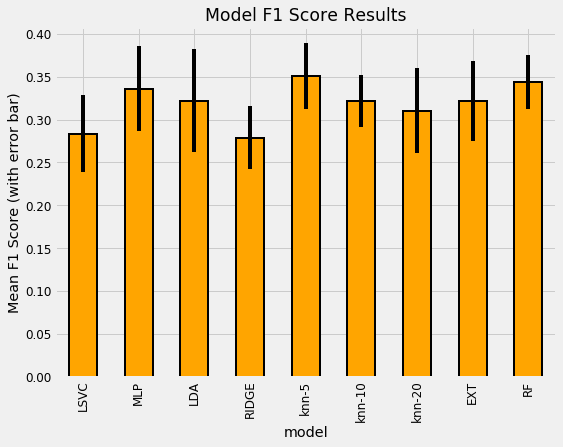

In [123]:
model_results.set_index('model',inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange',figsize = (8,6),
                                 yerr = list(model_results['cv_std']),
                                 edgecolor ='k',linewidth =2)
plt.title('Model F1 Score Results')
plt.ylabel('Mean F1 Score (with error bar)')
model_results.reset_index(inplace = True)

가장 가능성이 높은 후보는 랜덤 포레스트 (Random Forest) 인 것 같습니다. 하이퍼 파라미터를 튜닝하지 않았기 때문에 모델 간의 비교가 완벽하지는 않지만, 이러한 결과는 트리 기반 앙상블 방법 (그라디언트 부스팅 머신 포함)이 구조화 된 데이터 세트에서 매우 잘 수행된다는 것을 발견하는 다른 많은 Kaggle 경쟁사의 결과를 반영합니다. 하이퍼 파라미터 성능은 기계 학습 모델의 성능을 향상 시키지만 모든 모델에 대해 가능한 모든 설정 조합을 시도 할 시간이 없습니다. Randal Olson의 논문에서 아래 그래프는 하이퍼 파라미터 튜닝의 효과와 Scikit-Learn의 기본값에 대한 효과를 보여줍니다.


대부분의 경우 정확도 게인은 10 % 미만이므로 최악의 모델은 튜닝을 통해 갑자기 최고의 모델이되지 않을 것입니다.

지금은 랜덤 포레스트가 가장 좋다고 말할 것입니다. 나중에 Scikit-Learn에서는 구현되지 않았지만 Gradient Boosting Machine 사용에 대해 살펴 보겠습니다. 대신 더 강력한 LightGBM 버전을 사용합니다. 이제 랜덤 포리스트를 사용하여 제출을하겠습니다.


## Making a Sibmission

제출하려면 테스트 데이터가 필요합니다. 다행스럽게도 테스트 데이터는 열차 데이터와 정확히 같은 방식으로 형식화되었습니다.

테스트 제출 형식은 다음과 같습니다. 각 가정에 대해 예측을하고 있지만 실제로는 개인당 하나의 행 (ID로 식별)이 필요하지만 가정에 대한 예측 만 점수가 매겨집니다.

submission_base에는 각 개인에 대해 "예측"이 있어야하기 때문에 테스트 세트에있는 모든 개인이 있습니다. 반면 test_id에는 세대주 출신의 우상 만이 포함됩니다. 예측할 때 각 세대에 대해서만 예측 한 다음 예측 데이터 프레임을 세대 ID (idhogar)의 모든 개인과 병합합니다. 이렇게하면 가정의 모든 사람에게 대상이 동일한 값으로 설정됩니다. 세대주가없는 테스트 세대의 경우 점수가 매겨지지 않으므로 이러한 예측을 4로 설정할 수 있습니다.

In [124]:
test_ids = list(final.loc[final['Target'].isnull(),'idhogar'])

아래의 기능은 모델, 교육 세트, 교육 레이블 및 테스트 세트를 사용하여 다음 작업을 수행합니다.

적합을 사용하여 훈련 데이터에서 모형을 훈련시킵니다.
예측을 사용하여 테스트 데이터를 예측합니다.
경쟁 업체에 저장 및 업로드 할 수있는 제출 데이터 프레임을 만듭니다.

In [125]:
def submit(model, train, train_labels, test , test_ids):
    
    #훈련 데이터 
    model.fit(train, train_labels)
    predictions = model.predict(test)
    predictions = pd.DataFrame({'idhogar':test_ids, 'Target':predictions})
    
    # 제출용 데이터 프레임
    
    submission = submission_base.merge(predictions,
                                      on = 'idhogar',
                                      how = 'left').drop(columns = ['idhogar'])
    
    #
    submission['Target'] =submission['Target'].fillna(4).astype(np.int8)
    
    return submission


In [126]:
rf_submission = submit(RandomForestClassifier(n_estimators = 100,
                                             random_state = 10, n_jobs = -1),
                      train_set, train_labels, test_set, test_ids)
rf_submission.to_csv('rf_submission.csv', index = False)

## Feature Selection 
모델 성능을 향상시키는 한 가지 가능한 방법은 기능 선택입니다. 이것은 모델에 가장 유용한 기능 만 유지하려고하는 프로세스입니다. "가장 유용하다"는 여러 가지 의미를 가질 수 있으며 가장 중요한 기능을 선택하기위한 수많은 휴리스틱이 있습니다. 이 노트북에서 기능을 선택하려면 먼저 0.95보다 큰 상관 관계가있는 열을 제거하고 (기능 엔지니어링 중에이 중 일부를 이미 수행 했음) Scikit-Learn 라이브러리를 사용하여 재귀 적 기능 제거를 적용합니다.

먼저 상관 관계가 있습니다. 0.95는 임의의 임계 값입니다. 값을 자유롭게 변경하고 성능이 어떻게 변하는 지 확인하십시오!

In [127]:
train_set = pd.DataFrame(train_set,columns = features)

#
corr_matrix = train_set.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k =1).astype(np.bool))

#
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'elec', 'v18q-count', 'female-sum']

In [128]:
train_set = train_set.drop(columns = to_drop)
train_set.shape

(2973, 222)

In [129]:
test_set = pd.DataFrame(test_set, columns = features)
train_set, test_set = train_set.align(test_set, axis = 1, join = 'inner')
features = list(train_set.columns)

임의 포리스트를 사용한 재귀 기능 제거
Sklearn의 RFECV는 교차 검증을 통한 재귀 기능 제거를 나타냅니다. 선택기는 반복적으로 기능 중요도가있는 모델을 사용하여 작동합니다. 각 반복에서 기능의 일부 또는 정해진 수의 기능을 제거합니다. 교차 유효성 검사 점수가 더 이상 향상되지 않을 때까지 반복이 계속됩니다.

선택기 객체를 생성하기 위해 모델, 각 반복에서 제거 할 피처 수, 교차 검증 폴드, 사용자 지정 스코어러 및 선택을 안내하는 기타 매개 변수를 전달합니다.

In [130]:
from sklearn.feature_selection import RFECV

#
estimator =RandomForestClassifier(random_state = 10, n_estimators = 100, n_jobs = -1)

selector =RFECV(estimator, step = 1, cv = 3, scoring =score, n_jobs = -1)


그런 다음 다른 sklearn 모델과 마찬가지로 훈련 데이터에 선택기를 장착합니다. 교차 검증 점수가 더 이상 향상되지 않을 때까지 기능 선택이 계속됩니다.


In [131]:
selector.fit(train_set, train_labels)

RFECV(cv=3,
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=-1,
                                       oob_score=False, random_state=10,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=-1,
      scoring=make_scorer(f1_score, average=macro), step=1, verbose=0)

객체를 조사하여 각 반복에 대한 훈련 점수를 볼 수 있습니다. 다음 코드는 유효성 검사 점수와 교육 기능 수를 표시합니다.


58

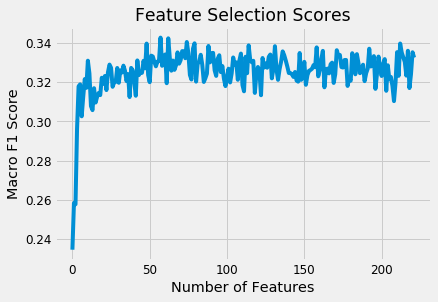

In [132]:
plt.plot(selector.grid_scores_)
plt.xlabel('Number of Features')
plt.ylabel('Macro F1 Score')
plt.title('Feature Selection Scores')
selector.n_features_
          

96 개의 기능까지 기능을 추가하면 점수가 향상되는 것을 알 수 있습니다. 선택기에 따르면 최적의 기능 수입니다.

훈련 된 개체를 검사하여 각 기능의 순위를 확인할 수 있습니다. 이는 본질적으로 반복에 대해 평균화 된 기능의 중요성을 나타냅니다. 기능은 동일한 순위를 공유 할 수 있으며 순위가 1 인 기능 만 유지됩니다.

In [133]:
rankings = pd.DataFrame({'feature': list(train_set.columns), 'rank':list(selector.ranking_)}).sort_values('rank')
rankings.head(10)

,feature,rank
73,r4h2,1
173,instlevel3-std,1
130,estadocivil7-std,1
129,estadocivil7-sum,1
198,escolari-sum,1
197,escolari-max,1
86,bedrooms,1
177,instlevel4-std,1
109,female-std,1
187,instlevel8-sum,1


마지막으로 기능을 선택한 다음 교차 검증으로 평가합니다.


In [136]:
train_selected = selector.transform(train_set)
test_selected = selector.transform(test_set)

In [139]:
# 데이터 프레임 전환
selected_features = train_set.columns[np.where(selector.ranking_ ==1)]
train_selected = pd.DataFrame(train_selected,columns = selected_features)
test_selected = pd.DataFrame(test_selected, columns = selected_features)

In [140]:
model_results = cv_model(train_selected, train_labels, model,'RFSEL',model_results)

10 Fold CV Score: 0.36248 with std: 0.0529


In [144]:
model_results

,cv_mean,cv_std
model,,
LSVC,0.283461,0.044843
MLP,0.336261,0.049519
LDA,0.322170,0.059842
RIDGE,0.278965,0.036746
knn-5,0.350777,0.038290
knn-10,0.321534,0.030284
knn-20,0.310388,0.049744
EXT,0.322154,0.046709
RF,0.343859,0.031338


In [154]:
import lightgbm as LGBMClasssifier

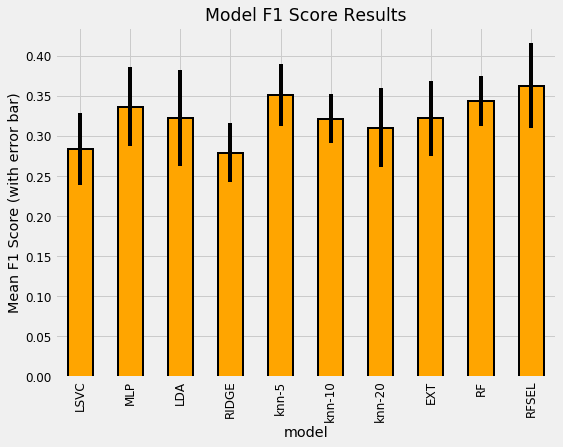

In [146]:
#model_results.set_index('model',inplace =True)
model_results['cv_mean'].plot.bar(color = 'orange',figsize = (8,6),
                                 yerr = list(model_results['cv_std']),
                                 edgecolor = 'k',linewidth =2)
plt.title('Model F1 Score Results')
plt.ylabel('Mean F1 Score (with error bar)')
model_results.reset_index(inplace=True)

선택한 기능이있는 모델은 교차 유효성 검사에서 약간 더 좋습니다. 다음 모델 인 Gradient Boosting Machine에서 사용할 수 있도록 두 가지 기능을 모두 유지할 수 있습니다.


## Upgrading Our Model: Gradient Boosting Machine

랜덤 포레스트를 사용하고 괜찮은 점수를 얻은 후에는 그라디언트 부스팅 머신을 단계적으로 사용하십시오. Kaggle에 시간을 투자하면 데이터가 구조화되고 (테이블 단위) 데이터 세트가 그다지 크지 않은 (백만 개의 관측치 미만) GBM (그라디언트 부스팅 머신)이 경쟁에서이기는 것을 알 수 있습니다.

여기서는 자세한 내용을 다루지 않고 구현에 중점을 둘 것입니다. Scikit-Learn, XGBOOST 및 CatBoost에도 옵션이 있지만 LightGBM에서 GBM을 사용합니다. 우리가 사용할 첫 번째 하이퍼 파라미터 세트는 내가 찾은 다른 문제에 대해 잘 작동 한 것을 기반으로했습니다.

### Choosing Number of Estimators with Early Stopping
추정기의 수 (n_estimators 또는 num_boost_rounds라고하는 앙상블의 의사 결정 트리 수)를 선택하기 위해 5 배 교차 검증으로 조기 중지를 사용합니다. 이렇게하면 Macro F1 Score로 측정 한 성능이 100 번의 훈련 라운드 동안 증가하지 않을 때까지 추정값을 계속 추가 할 수 있습니다. 이 측정 항목을 사용하려면 맞춤 측정 항목을 정의해야합니다




In [173]:
def macro_f1_score(labels, predictions):
    ##
    predictions = predictions.reshape(len(np.unique(labels)),-1).argmax(axis =0)
    
    metric_value = f1_score(labels, predictions, average = 'macro')
    
    return 'macro_f1', metric_value, True
    

## Light Gradient Boosting Machine Implementation
아래 기능은 Stratified Kfold 교차 검증 및 조기 정지 기능을 사용하여 그라디언트 부스팅 머신을 교육하여 훈련 데이터에 과적 합을 방지합니다 (여전히 발생할 수는 있음). 이 함수는 교차 검증을 통해 훈련을 수행하고 각 접기에 대해 확률로 예측을 기록합니다. 이것이 어떻게 작동하는지 확인하기 위해 각 접기에서 예측을 반환 한 다음 제출물을 반환하여 경쟁에 업로드 할 수 있습니다.

그라디언트 부스팅 머신의 하이퍼 파라미터를 선택하는 것은 어렵고 일반적으로 모델 최적화를 통해 수행됩니다. 이 노트에서는 이전 문제에서 제대로 작동하는 것으로 밝혀진 일련의 하이퍼 파라미터를 사용합니다.

n_estimators를 10000으로 설정했지만 조기 검증을 사용하고 있기 때문에 교차 검증 메트릭이 early_stopping_rounds에 대해 개선되지 않을 때 훈련 추정기를 종료하기 때문에 실제로이 수에 도달하지 않습니다. 이 기능에는 많은 것들이 진행 중이며,주의 깊게 읽어보고 모든 것을 갖추 었는지 확인하십시오! 주석과 코드를 간단하게 만들려고 노력했습니다. (디스플레이는 훈련 중 사용자 정의 정보를 %% 캡처와 함께 표시하는 데 사용되므로 훈련 중에 모든 LightGBM 정보를 볼 필요는 없습니다)

In [184]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from IPython.display import display

def model_gbm(features, labels, test_features, test_ids,
             nfolds = 5, return_preds = False, hyp = None):
    """Model using the GBM and cross validation.
       Trains with early stopping on each fold.
       Hyperparameters probably need to be tuned."""
    
    feature_names = list(features.columns)
     
    # Option for user specified hyperparameters
    if hyp is not None:
        #
        if 'n_estimators' in hyp:
            del hyp['n_estimators']
        params = hyp
    else:
        params = {'boosting_type':'dart',
                 'colsample_bytree':0.88,
                 'learning_rate':0.028,
                 'min_child_samples':10,
                 'num_leaves':36,
                 'reg_alpha':0.76,
                 'reg_lambda':0.43,
                 'subsample_for_bin':40000,
                 'subsample':0.54,
                 'class_weight':'balanced'}
    # 모델 구축
    model = lgb.LGBMClassifier(**params, objective = 'multiclass',
                               n_jobs = -1, n_estimators = 10000,
                               random_state = 10)
    #교차검증
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle =True)
    
    # 각 폴드 예측 값
    predictions = pd.DataFrame(features)
    importances = np.zeros(len(feature_names))
    
    ## array 배열로 인덱싱 
    features = np.array(features)
    test_features = np.array(test_features)
    labels = np.array(labels).reshape((-1))
    
    valid_scores = []
    
    # 각 폴드 반복
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
               
        # 각 폴드 예측
        fold_predictions = pd.DataFrame()
        # 데이터 셋  구분
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        #
        model.fit(X_train,y_train,early_stopping_rounds = 100,
                 eval_metric = macro_f1_score,
                 eval_set = [(X_train,y_train), (X_valid,y_valid)],
                 eval_names = ['train','valid'],
                 verbose = 200)
        
        #각 폴드 검증 점수 기록
        
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        
        #
        fold_probabilities = model.predict_proba(test_features)
        
        #
        for j in range(4):
            fold_predictions[(j+1)] = fold_probabilities[:, j]
        
        # 예측 값 넣기
        fold_predictions['idhogar'] = test_ids
        fold_predictions['fold'] = (i+1)
        
        #변수 중요도
        importances += model.feature_importances_ / nfolds
        
        #
        display(f'Fold{i+1}, Validation Score:{round(valid_scores[i],5)}, Estimators Traioned: {model.best_iteration_}')
        
        #변주 중요도 데이터 프레임
        feature_importances = pd.DataFrame({'feature':feature_names,
                                           'importance':importances})
        
        valid_scores = np.array(valid_scores)
        display(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std:{round(valid_scores.std(),5)}.')
        
        #
        if return_preds:
            predictions['Target'] = predictions[[1,2,3,4,]].inxmax(axis =1)
            predicionts['confidence'] = predictions[[1,2,3,4]].max(axis =1)
            return predictions, feature_importances
        
        # 폴드 평균 계산
        predictions = predictions.groupby('idhogar',as_index = False).mean()
        
        #
        predictions['Target'] = predictions[[1,2,3,4]].inxmax(axis = 1)
        predictions['confidence'] = predictions[[1,2,3,4]].max(axis =1)
        predictions = predictions.drop(columns = ['fold'])
        
        #
        submission = submission_base.merge(predictions[['idhogar','Target']], on = 'idhogar',how = 'left').drop(columns = ['idhogar'])
        
        #
        submission['Target'] = submission['Target'].fillna(4).astype(np.int8)
        
        return submussion, feature_importances, valid_scores
            
    

## Cross Validation with Early Stopping Notes
조기 중지를 통한 교차 검증은 검증 점수가 향상되지 않는 것이 확실 해지면 모델 복잡성을 계속 추가 할 수 없기 때문에 훈련 세트에서 과적 합을 방지하는 가장 효과적인 방법 중 하나입니다. 여러 번 접는 과정에서이 과정을 반복하면 한 번 접을 때 발생하는 편향을 줄일 수 있습니다. 조기 정지는 또한 모델을 훨씬 빠르게 훈련시킵니다. 전반적으로 교차 검증으로 조기 중지하는 것이 그라디언트 부스팅 머신에서 추정기의 수를 선택하는 가장 좋은 방법이며 구현을 구현할 때 기본 기술이어야합니다.


In [ ]:
%%capture --no-display
predictions, gbm_fi = model_gbm(train_set,train_labels,test_set,test_ids,return_preds = True)


그라디언트 부스팅 머신의 힘을 여기서 볼 수 있습니다! 교차 검증 점수는 이전에 수행 한 모든 것을 날려 버립니다.

각 접힘에서 예측이 어떻게 진행되는지 이해하기 위해 예측을 살펴 보겠습니다.

In [160]:
predictions.head()

NameError: name 'predictions' is not defined

각 접힘에 대해 1, 2, 3, 4 열은 각 대상의 확률을 나타냅니다. 목표는 확률을 확신하는 최대 값입니다. 우리는 5 개의 모든 폴드에 대한 예측을 가지고 있으므로, 각 폴드에 대한 다른 폴드에 대한 신뢰를 그릴 수 있습니다.

In [ ]:
plt.rcParmas['font.size'] = 18

#kdeplot
g = sns.FacetGrid(predictions, row = 'fold',hue = 'Target',size =3, aspect =4)
g.map(sns.kdeplot, 'confidence')
g.add_legend()
plt.subtitle('Distribution of Confidence by Fold and Target', y= 1.05)

여기서 볼 수있는 것은 상대적으로 낮은 경우 각 클래스에 대한 신뢰입니다. 이 모델은 클래스 불균형과이 레이블의 높은 유병률로 인해 Target = 4 예측에 대한 신뢰도가 더 높은 것으로 보입니다.

정보를 보는 또 다른 방법은 바이올린 플롯입니다. 이것은 플롯 폭과 관련된 관측치 수와 동일한 정보를 표시합니다.

In [ ]:
plt.figure(figsize = (24,12))
sns.violinplot( x= 'Target',y = 'confidence', hue = 'fold', data = predictions)


In [ ]:
전반적으로,이 결과는 불균형 된 클래스 문제와 관련된 문제를 보여줍니다. 우리 모델은 표현되지 않은 클래스를 잘 구별 할 수 없습니다. 나중에 예측 자체를 살펴보고 모델이 "혼란 된"위치를 봅니다. 지금은 제출 파일을 생성하여 경쟁 업체에 제출할 수 있습니다.

실제로 각 가정에 대해 예측할 때 각 접힘의 예측을 평균화합니다. 따라서 각각의 모델이 약간 다른 데이터에 대해 학습되므로 본질적으로 여러 모델을 사용합니다. 그래디언트 부스팅 머신은 이미 앙상블 머신 러닝 모델이며, 이제는 몇 gbms의 예측을 평균화하여 거의 메타 앙상블로 사용하고 있습니다.

이 프로세스는 아래 코드에 나와 있습니다.

In [ ]:
## 각 폴드 예측 점수 평균
predictions = predictions.groupby('idhogar',as_index =False).mean()

#
predictions = ['Target'] = predictions[[1,2,3,4]].idxmax(axis = 1)
predictions = ['confidence'] = predictions[[1,2,3,4]].max(axis =1)
predictions = predictions.drop(columns = ['fold'])

# 신뢰도 boxplot
plt.figure(figsize = (10,6))
sns.boxplot(x= 'Target', y= 'confidence',data =predictions)
plt.title('Confidence by Target')

plt.figure(figsize = (10,6))
sns.violinplot(x= 'Target',y = 'confidence', data = predictions))
plt.title('Confidence by Target')

대신 실제 제출 파일을 반환하는 함수를 가질 수 있습니다. 이것은 5 개의 폴드에 대한 평균 예측을 취하며, 5 개의 서로 다른 모델을 결합하는데, 각 모델은 약간 다른 데이터 서브 세트에 대해 훈련됩니다.


In [ ]:
%%capture
submission, gbm_fi, valid_scores = model_gbm(train_set,train_labels,
                                            test_set,test_ids,return_preds = False)
submisison.to_csv('gmb_baseline.csv')

In [ ]:
_ = plot_feature_importances(gbm_fi, threshold = 0.95)

In [ ]:

gbm은 가장 중요한 기능은 연령대에서 파생 된 것이라고 생각합니다. 교육 변수도 가장 중요한 특징으로 나타납니다.

선택한 기능 사용해보기

LightGBM의 다음 단계는 재귀 적 기능 제거를 통해 선택된 기능을 시도하는 것입니다.

In [ ]:
%%capture --no-display
submission, gbm_fi_selected, valid_scores_selected = model_gbm(train_selected,train_labels,test_selected,test_ids)

In [ ]:
mode_results = model_results.append(pd.DataFrame({'model',:['GBM','GBM_SEL'],
                                                 'cv_mean':[valid_scores.mean(),valid_scores_selected.mean()],
                                                 'cv_std':[valid_scores.std(),valid_scores_selected.std()]}),
                                   sort = True)

In [ ]:
model_results.set_index('model',inplace =True)
model_results['cv_mean'].plot.bar(color = 'orange',figsize = (8,6),
                                 yerr = list(model_results['cv_std']),
                                 edgecolor ='k',linewidth = 2)
plt.title('Model F1 Score Results')
plt.ylabel('Mean F1 Score (with error bar)')
model_results.set_inde(inplace =True)

그라디언트 부스팅 머신의 큰 장점이 여기에 표시됩니다. 마지막 단계로, 두 세트와 함께 10 배를 사용하여 플롯에 추가해 봅시다.


In [ ]:
%% capture
submission,gbm_fi, valid_scores = model_gbm(train_set,train_labels,test_set,test_ids,nfold = 10 , return_preds =False)

In [ ]:
submission.to_csv('gbm_10fold.csv',index =False)


In [ ]:
%% capture
submission,gbm_fi_selected,valid_scores_selected = model_gbm(train_selected,train_labels,test_selected,test_ids,
                                          nfold =10 )

In [ ]:
submission.to_csv('gmb_10fold_selected.csv',index = False)

In [ ]:
model_results = model_results.append(pd.DataFrame({'model':['GBM_10Fold','GBM_10Fold_SEL'],
                                                  'cv_mean':[valid_scores.mean(),valid_scores_selected.mean()],
                                                  'cv_std':[valid_scores.std(),valid_scores_selected.std()]}), sort =True)

가장 좋은 모델은 선택한 기능에 대해 10 배로 훈련 된 그라디언트 부스팅 머신 인 것 같습니다. 이 모델은 아직 최적화되지 않았지만 최적화를 통해 성능이 약간 향상 될 수 있습니다.


## Model Optimization 
모델 최적화는 교차 검증을 통해 하이퍼 파라미터를 조정하여 기계 학습 모델에서 최상의 성능을 추출하는 프로세스입니다. 최상의 모델 하이퍼 파라미터는 모든 데이터 세트마다 다르기 때문에이 작업이 필요합니다.

이 노트북에서는 모델 튜닝에 대해 너무 많이 다루지는 않지만 여러 옵션이 있습니다.

설명서
그리드 검색
무작위 검색
자동화 된 최적화
이 방법은 일반적으로 가장 효율적인 방법이며 Tree Parzen Estimator와 함께 수정 된 Bayesian Optimization 버전을 사용하는 Hyperopt를 포함한 여러 라이브러리에서 쉽게 구현할 수 있기 때문에 4를 고수 할 것입니다.

## Model Tuning with hyperor
베이지안 최적화에는 4 가지 부분이 필요합니다.

목표 함수 : 우리가 최대화하고 싶은 것
도메인 공간 : 검색 할 지역
다음 하이퍼 파라미터 선택 알고리즘 : 과거 결과를 사용하여 다음 값 제안
결과 기록 : 과거 결과를 저장합니다
이전에 Hyperopt 사용에 대해 작성 했으므로 여기서는 구현을 고수합니다.


In [ ]:
from hyperopt import hp, tpe, Trials, fmin,STATUS_OK
from hyperopt.pyll.stochastic import sample


In [ ]:
import csv
import ast
from timeit import default_timer as timer

### 1.Objective Function
모델 하이퍼 파라미터를 가져와 관련 유효성 검사 점수를 반환합니다. Hyperopt는 최소화하기 위해 점수가 필요하므로 1-Macro F1 점수를 반환합니다.

In [135]:
def objective(hyperparameters, nfols =5):
    
    # 
    global ITERATION
    ITERATION +=1
    #
    subsample = hyperparameters['boosting_type'].get('subsample',1.0)
    subsample_freq = hyperparameters['boosting_type'].get('subsample_freq',0)
    
    boosting_type = hyperparameters['boosting_type']['boosting_type']
    
    if boosting_type =='dart':
        hyperparameters['drip_rate'] = hyperparameters['boosting_type']['drop_rate']
        
        #
        hyperparameters['subsample'] = subsample
        hyperparameters['subsample_freq'] = subsample_freq
        hyperparameters['boosting_type'] = boosting_type
        
        #
        if not hyperparameters['limit_max_depth']:
            hyperameters['max_depth'] = -1
            
        #
        for parameter_name in ['max_depth','num_leaves','subsample_for_bin',
                              'mon_child_samples','subsample_freq']:
            hyperparameters[parameter_name] = int(hyperparameters[parameter_name])
        
        if 'n_estimators' in hyperparameters:
            del hyperparameters['n_estimators']
            
        #
        strkfold = StratifiedKFold(n_splits = nfolds, shuffle =True)
        
        #
        features = np.array(train_selected)
        labels = np.array(train_labels).reshape((-1))
        
        valid_scores = []
        best_estimators = []
        run_time = []
        
        model = lgb.LGBMClssifier(**hyperparameters, class_weight = 'balanced',n_jobs =-1,metric = 'None',n_estimators = 10000)
        
        #
        for i , (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
            
            #
            X_train = features[train_indices]
            X_valid = features[valid_indices]
            y_train = labels[train_indices]
            y_valid = labels[valid_indices]
            
            start = timer()
            
            estimators = int(np.mean(best_estimators))
          
            
            model.fit(X_train, y_train, early_stopping_rounds = 100,
                     eval_metric = macro_f1_score,
                     eval_set = [(X_train,y_train),(X_valid,y_valid)],
                     eval_names = ['train','valid'],
                     verbose = 400)
            end = timer()
            #
            valid_scores.append(model.best_score_['valid']['macro_f1'])
            best_estimators.append(model.best_iteration_)
            
            run_times.append(end - start)
        score = np.mean(valid_scores)
        score_std = np.std(valid_scores)
        loss = 1-score
        
        run_time = np.mean(run_times)
        run_time_std = np.std(trun_times)
        
        estimators = int(np.mean())
        hyperparameters['n_estimators'] = estimators
        #
        of_connection = open(OUT_FILE, 'a')
        writer = csv.writer(of_connection)
        writer.writerow([loss,hyperparameters,ITERATION,run_time,score, score_std])
        of_connection.close()
        
        
        
        if ITERATION %PROGRESS ==0:
            display(f'Iteration : {ITERATION}, Current Score: {round(score, 4)}.')
            
        return{'loss':loss, ' hyperparameters':hyperparameters,'iteration':ITERATION,
              'time':run_time, 'time_std':run_time_std,'status':STATUS_OK,
              'score':score, 'score_std':score_std}


### 2. Search Space
도메인은 검색하려는 전체 값 범위입니다. 가장 어려운 부분은 boosting_type = "goss"인 경우 1.0으로 설정해야하는 서브 샘플 비율입니다. 여기의 값으로 자유롭게 놀아보십시오.

In [ ]:
space ={
    'boosting_type':hp.choice('boosting_type',
                             [{'boosting_type':'gbdt',
                              'subsample':hp.uniform('gdbt_subsample',0.5,1),
                              'subsample_freq':hp.quniform('gbdt_subsample_freq',1,10,1)},
                             
                              {'boosting_type':'dart',
                             'subsample':hp.uniform('dart_subsample',0.5,1),
                              'subsample_freq': hp.quniform('dart_subsample_freq',1,10,1),
                              'drop_rate':hp.uniform('dart_drop_rate',0.1,0.5)},
                             {'boosting_type':'goss',
                             'subsample':1.0,
                             'subsample_freq':0}]),
    'limit_max_depth':hp.choice('limit_max_depth',[True,False]),
    'max_depth':hp.quniform('max_depth',1,40,1),
    'num_leaves':hp.quniform('num_leaves',3,50,1),
    'learning_rate':hp.loguniform('learning_rate',np.log(0.025),
                                 np.log(0.25)),
    'subsample_for_bin':hp.quniform('subsample_for_bin',2000,100000,2000),
    'min_child_samples':hp.quniform('min_child_samples',5,80,5),
    'reg_alpha':hp.uniform('reg_alpha',0.0,1.0),
    'reg_lambda':hp.uniform('reg_lambda',0.0,1.0),
    'colsample_bytree':hp.uniform('colsample_by_tree',0.5,0.1)
}

In [ ]:
smaple(space)

### 3.알고리즘
다음 값을 선택하는 알고리즘은 목적 함수의 대리 모델을 구성하기 위해 베이 즈 규칙을 사용하는 Tree Parzen Estimator입니다. 알고리즘은 목적 함수를 최대화하는 대신 대리 모델의 EI (Expected Improvement)를 최대화합니다.


In [ ]:
algo = tpe.suggest

### 4.Results History
결과를 기록하기 위해 두 가지 방법을 사용합니다.

평가판 개체 : 목적 함수에서 반환 된 모든 내용을 저장합니다.
반복 할 때마다 CSV 파일에 쓰기
중복을 의미하므로 진행 상황을 추적하기 위해 여러 가지 방법을 사용하는 것이 좋습니다. 한 가지 방법은 실패 할 수 있지만 두 가지 방법 모두 그렇지 않습니다! csv 파일을 사용하여 메서드가 실행되는 동안 메서드를 모니터링하고 Trials 개체를 저장 한 다음 다시로드하여 최적화를 다시 시작할 수 있습니다.

In [ ]:
trials = Trials()

OUT_FILE = 'optimization.csv'
of_connection = open(OUT_FILE,'w')
writer = csv.writer(of_connection)

MAX_EVALS = 100
PROGRESS = 10
N_FOLDS =5
ITERATION = 0

headers = ['loss','hyperparameters','iteration','runtime','score','std']
writer.writerow(headers)
of_connection.close()


In [ ]:
%% capture --no-display
display('Running Optimization for {} Trials.'.format(MAX_EVALS))

best = fmin(fn = objective,space = space, algo = tpe.suggest, trials = trials, max_evals = MAX_EVALS)


훈련을 다시 시작하기 위해 동일한 평가판 개체를 전달하고 최대 반복 횟수를 늘릴 수 있습니다. 나중에 사용하기 위해 평가판을 json으로 저장할 수 있습니다.


In [ ]:
import json 
with open('trials.json','w') as f:
    f.write(json.dumps(str(trials)))

### Using Optimized Model
최적화 절차가 끝나면 최상의 모델링 결과를 사용할 수 있습니다.


In [ ]:
results = pd.read_csv(OUT_FILE).sort_values('loss',ascending =True).reset_index()
results.head()

In [ ]:
plt.figure(figsize = (8,6))
sns.regplot('iteration','score',data =results)
plt.title('Optimization Scores')
plt.xticks(list(range(1, results['iteration'].max() + 1, 3)))

In [ ]:

best_hyp = ast.literal_eval(results.loc[0,'hyperparameters'])
best_hyp

In [ ]:
%%capture
submission,gbm_fi,valid_scores = model_gbm(train_selected,train_labels,
                                          test_selected,test_ids,
                                          nfold = 10,return_preds = True)
model_results = model_results.append(pd.DataFrame({'model':['GBM_OPT_10Fold_SEL'],
                                                  'cv_mean':[valid_scores.mean()],
                                                  'cv_std':[valid_scores.std()]}),
                                    sort = True).sort_values('cv_mean',ascending=True)


In [ ]:
%%capture
submission, gbm_fi, valid_scores = model_gbm(train_set,train_labels,
                                            test_set, test_ids,
                                            nfolds =10, return_preds = False)
model_results = model_reults.append(pd.DataFrame({'model':['GBM_OPT_10Fold'],
                                                 'cv_mean':[valid_scores.mean()],
                                                 'cv_std':[valid_scores.std()]}),
                                   sort = True).sort_values('cv_mean',ascending =True)


In [ ]:
model_results.head()

In [ ]:
submission.to_csv('gbm_opt_10fold_selelcted.csv',index = False)

이 시점에서 성능을 개선하기 위해 최적화를 계속하고, 더 많은 기능 엔지니어링을 시도하고, 추가 모델을 스택 또는 앙상블하거나, 치수 축소 또는 오버 샘플링과 같은 실험적인 방법을 살펴볼 수 있습니다. 그러나 우리가 얻는 점수는 상당히 좋으며 기계 학습의 중요한 부분으로 넘어갈 것입니다. 예측을 조사하여 모델이 잘못된 위치를 봅니다.

Kaggle은 사실적인 데이터 세트를 제공하는 데 유용하지만 리더 보드의 최상위에 도달하는 데 필요한 방법은 일반적으로 현실에서는 사용되지 않습니다. 어느 정도 수준의 성능을 넘어 서면 정확성은 해석 가능성을 뒷받침합니다. 사람들은 인간이 자신의 결정을 설명 할 수 있기를 원하는 것처럼 모델이 예측하는 이유를 알고 싶어합니다. 우리는 모델에서 더 많은 성능을 끌어낼 수는 있지만, 현재 모델을 조사하는 데 에너지가 더 많이 사용됩니다.

In [ ]:
_ = plot_feature_importances(gbm_fi)

### Investigate Predictions
모델을 조사하기위한 첫 번째 시도로서 테스트 데이터에서 예측 된 레이블의 분포를 시각화 할 수 있습니다. 우리는 이것들이 훈련 데이터와 같은 분포를 보여줄 것으로 기대합니다. 우리는 가계 예측에 관심이 있기 때문에 각 주택에 대한 예측 만 살펴보고 훈련 데이터의 예측과 비교합니다.

다음 히스토그램은 정규화되어 절대 계수 대신 상대 주파수를 나타냅니다. 이는 훈련 및 테스트 데이터에서 원시 수가 다르기 때문에 필요합니다.


In [ ]:
preds = submission_base.merge(submission,on= 'Id',how = 'left')
preds = pd.DataFrame(preds.groupby('idhogar')['Target'].mean())

#
fig, axes = plt.subplots(1,2,sharey = True,figsize = (12,6))
heads['Target'].sort_index().plot.hist(normed = True,
                                      edgecolor = r'k',
                                      linewidth = 2,
                                      ax = axes[0])

axes[0].set_xticks([1,2,3,4])
axes[0].set_xticklabels(poverty_mapping.values(),rotation = 60)
axes[0].set_title('Train Label Distribution')

preds['Target'].sort_index().plot.hist(normed = True,
                                      edgecolor = 'k',
                                      linewidth =2,
                                      ax = axes[1])

axes[1].set_xticks([1,2,3,4])
axes[1].set_xticklabels(poverty_mapping.values(),rotation = 60)
plt.subplots_adjust()
plt.title('Predicted Label Distribution')

In [ ]:
heads['Target'].value_counts()

In [ ]:
preds['Target'].value_counts()

약간의 차이가 있지만 예측 분포는 훈련 분포와 비슷하게 보입니다. 노트북 실행에 따라 표시되는 결과가 변경 될 수 있지만이 버전의 경우 예측에서 4가 부족하고 3이 과도하게 나타납니다.

불균형 분류 문제를 처리하는 잠재적 인 방법 중 하나는 소수 클래스를 오버 샘플링하는 것인데, 이는 불균형 학습 라이브러리를 사용하여 Python에서 쉽게 수행 할 수 있습니다. 여기서는 그 옵션을 살펴 보지 않을 것입니다.

### Validation
테스트 예측의 경우 분포를 훈련 데이터에서 찾은 분포와 비교할 수만 있습니다. 예측과 실제 답변을 비교하려면 교육 데이터를 별도의 유효성 검사 세트로 분할해야합니다. 테스트에 1000 개의 예제를 사용한 다음 정답이 있기 때문에 혼동 행렬 만들기와 같은 작업을 수행 할 수 있습니다

In [ ]:
from sklearn.model_selection import train_test_split

# 
X_train, X_valid, y_train,y_valid = train_test_split(train_selected,
                                                    train_labels,
                                                    test_size = 1000,
                                                    random_state = 10)

model = lgb.LGBMClassifier(**best_hyp,
                          class_weight = 'balanced',
                          random_state = 10)
model.fit(X_train, y_train)

In [ ]:
valid_preds = model.predict_proba(X_valid)
preds_df = pd.DataFrame(valid_preds, columns = [1,2,3,4])

preds_df['prediction'] = preds_df[[1,2,3,4]].indxmax(axis =1)
preds_df['confidence'] = preds_df[[1,2,3,4]].max(axis =1)

preds_df.head()

In [ ]:
print('F1 score:',round(f1_score(y_valid, preds_df['prediction'],average = 'macro'),5))


예측을 사용하여 혼동 행렬을 그려 봅시다. 이를 통해 예측과 실제 값의 차이를 표시하여 모델이 "혼란 된"위치를 확인할 수 있습니다. 이 혼동 매트릭스의 코드는 다음에서 수정됩니다. http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm,classes,
                         normalize = False,
                         title = 'Confusion matrix',
                         cmap = plt.cm.Oranges):
    
    if normalize:
        cm = cm.astype('float')/ cm.sum(axis =1)[:,np.newaxis]
        print('Normalized confusion matrix')
        
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    
    plt.figure(figsize = (10,10))
    plt.imshow(cm,interpolation = 'nearest',cmap = cmap)
    plt.title(title, size =24)
    plt.colorbar(aspect =4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation =45, size =14)
    plt.yticks(tick_marks,classes,size =14)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() /2.
    
    for i , j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),fontsize =20,
                 horizontalalignment = 'center',
                 color = 'white' if cm[i,j] > thresh else 'black')
    
    plt.grid(None)
    plt.tight_layout()
    plt.ylabels('True label',size =18)
    plt.xlabel('Predicted label', size =10)

In [ ]:
cm = confusion_matrix(y_valid, preds_df['prediciton'])

plot_confusion_matrix(cm, classes = ['Extreme','Moderate','Vulerable','Non-Vulnerable'],
                     title= 'Poverty Confusion Matrix')


혼동 행렬을 읽는 방법은 다음과 같습니다. 예측 된 값이 실제 값과 일치하기 때문에 대각선에있는 값 중 하나라도 모형이 정확합니다. 대각선에 있지 않은 것은 모델이 잘못되어 예측값과 실제 값을 비교하여 평가할 수 있습니다.

예를 들어, 우리 모델은 빈곤이 극심한 25 개의 관측치를 정확하게 예측했습니다. 반면 빈곤이 극심한 26 건의 경우, 우리 모델은 중간 정도라고 예측했다. 빈곤이 취약하지 않은 95 건의 경우, 우리 모델은 빈곤이 취약한 것으로 예측했다. 전반적으로, 우리는 우리의 모델이 취약하지 않은 가정을 식별하는 데 매우 정확하다는 것을 알았습니다.

각 클래스에서 예측되는 각 실제 레이블의 백분율을 확인하기 위해 실제 레이블에 대한 혼동 행렬을 정규화 할 수 있습니다.

In [ ]:
plot_confusion_matrix(cm, normalize = True,
                     classes = ['Extreme','Moderate','Vulnerable','Non-Vulnerable'],
                     title = 'Poverty Confusion Matrix')

이제 우리는 모델이 비 취약성 이외의 클래스에서는 실제로 그렇게하지 않는다는 것을 알 수 있습니다. 취약한 가구의 15 % 만 정확하게 식별하여 이들 중 대부분을 보통 또는 비 취약으로 분류합니다. 전반적으로, 이러한 결과는 상대적으로 관측이 적은 불균형 분류 문제가 매우 어렵다는 것을 보여줍니다. 데이터의 서로 다른 섹션에서 여러 모델을 오버 샘플링 또는 훈련하는 것과 같이이를 시도하고 해결하기 위해 취할 수있는 몇 가지 방법이 있지만 하루가 끝날 때 가장 효과적인 방법은 더 많은 데이터를 수집하는 것일 수 있습니다.


### Dimension Reduction 
문제의 최종 탐색으로 선택한 데이터 세트에 몇 가지 다른 차원 축소 방법을 적용 할 수 있습니다. 이러한 방법은 시각화 또는 기계 학습을위한 전처리 방법으로 사용할 수 있습니다. 우리는 네 가지 방법을 살펴 보겠습니다 :

PCA : 주요 구성 요소 분석. 데이터에서 가장 큰 변화의 차원을 찾습니다.
ICA : 독립 성분 분석. 가변 변량 신호를 독립된 신호로 분리하려고 시도합니다.
TSNE : T- 분산 된 확률 적 이웃 임베딩. 데이터 내에서 로컬 구조를 유지하려고 시도하면서 고차원 데이터를 저 차원 매니 폴드에 매핑합니다. 비선형 기술이며 일반적으로 시각화에만 사용됩니다.
UMAP : 균일 매니 폴드 근사화 및 투영 : 데이터를 저 차원 매니 폴드에 매핑하지만 TSNE보다 더 많은 전역 구조를 유지하려고하는 비교적 새로운 기술입니다.
이 네 가지 방법 모두 파이썬에서 구현하기가 비교적 간단합니다. 선택한 기능을 시각화를 위해 3 차원으로 매핑 한 다음 모델링 기능으로 PCA, ICA 및 UMAP을 사용합니다 (TSNE에는 변환 방법이 없으므로 전처리에 사용할 수 없음).

In [ ]:
from umap import UMAP
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE

n_components=3
umap = UMAP(n_components = n_components)
pca = PCA(n_components = n_components)
ics = FastICA(n_componenets = n_components)
tsne = TSNE(n_components = n_components)

In [ ]:
train_df = train_selected.copy()
test_df = test_selected,copy()

for method, name in zip([umap,pca,ica,tsne],
                       ['imap','pca','ica','tsne']):
    
    ##
    if name =='tsne':
        start = timer()
        reduction = method.fit_transform(train_selected)
        end = timer()
    
    else:
        start = timer()
        reduction = method.fit_transform(train_selected)
        end = timer()
        
        test_reduction = method.transform(train_selected)
        
        test_df['%s_c1'% name] =test_reduction[:,0]
        test_df['%s_c2'% name] =test_reduction[:,1]
        test_df['%s_c3'% name] =test_reduction[:,2]
    train_df['%s_c1'%name] =reduction[:,0]
    train_df['%s_c2'%name] =reduction[:,1]
    train_df['%s_c3'%name] =reduction[:,2]
    
    print(f'Method:{name} {round(end - start, 2)} seconds elapsed.')
    

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def discrete_cmap(N, base_cmap = None):
    
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linespace(0,1,N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

cmap = discrete_cmap(4, base_cmap = plt.cm.RdYlBu)

train_df['label'] = train_lables

In [ ]:
for method, name in zip([umap,pca,ica, tsne],
                       ['umap','pca','ica','tsne']):
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111, projection ='3d')
    
    p = ax.scatter(train_df['%s_c1' %name], train_df['%s_c2' %name], train_df['%s_c3' % name], c = train_df['label'].astype(int), cmap = cmap)
    
    plt.title(f'{name.capitalize()}',size =22)
    fig.colorbar(p,aspect = 4, ticks = [1,2,3,4])


이 도표에서 많은 군집화를보기는 어렵습니다. 이는 가용 한 데이터를 고려할 때 빈곤층 분리가 어렵다는 것을 나타냅니다. 머신 러닝 모델은 우리가 제공 한 데이터만큼 효과적이며 때로는 데이터에 충분한 정보가 없습니다.

마지막 단계로 PCA, ICA 및 UMAP의 추가 축소를 사용하여 모델을 학습 할 수 있습니다. 최적화와 동일한 Light GBM 하이퍼 파라미터를 사용합니다

In [ ]:
train_df, test_df = train_df.align(test_df, axis = 1, join = 'inner')

In [ ]:
%%capture

submission,gbm_fi, valid_scores = model_gbm(train_df,train_labels,
                                            test_df,test_ids,nfolds =10,
                                            hyp = best_hyp)

In [ ]:
submission.to_csv('gbm_opt_10fold_df.csv',index= False)


In [ ]:
model_results = model_results.append(pd.DataFrame({'model':['GBM_OPT_10Fold_DR'],
                                                  'cv_mean':[valid_scores.mean()],
                                                  'cs_std':[valid_scores.std()]}),
                                    sort = True)

In [ ]:
model_results = model_results.sort_values('cv_mean')
model_results.set_index('model',inplace= True)
model_results['cv_mean'].plot.bar(color = 'orange',figsize = (10,8),
                                 edgecolor = 'k',linewidth =2,
                                 yerr = list(model_results['cv_std']))

plt.title('Model F1 Score Results')
plt.ylabel('Mean F1 Score (with error bar)')
model_results.set_index(inplace= True)

치수 축소 구성 요소는 모델의 전체 점수를 약간 떨어 뜨 렸습니다. 훈련 데이터에만 과도하게 적합 할 수 있습니다.


In [ ]:
_ = plot_feature_importances(gbm_fi)

치수 축소 구성 요소의 중요성이 높기 때문에 과적 합의 원인이 될 수 있습니다. 치수 축소 방법에서는 레이블 정보를 사용하지 않으므로 모델에 유용한 정보가 없을 수도 있습니다.


### Visualize Single Decision Tree

마지막 단계로 임의 포리스트에서 하나의 의사 결정 트리를 볼 수 있습니다. 먼저 가시성을 위해 최대 깊이를 제한 한 다음 트리를 끝까지 확장합니다.

첫 번째 단계는 단순히 임의의 포리스트를 학습하고 하나의 트리를 추출하는 것입니다 (단일 결정 트리를 훈련 할 수도 있음).

In [ ]:
model = RandomForestClassifier(max_depth = 3, n_estimators =10)
model.fit(train_selected, train_labels)
estimator_limited = model.estimators_[5]
estimator_limited

훈련 된 트리를 가져 와서 export_graphviz를 사용하여 .dot 파일로 내 보냅니다.


In [ ]:
from sklearn.tree import export_graphviz

export_graphciz(estimator_limited, out_fild = 'tree_limited.dot', feature_name = train_selected.columns,
               class_names = ['extreme','moderate','vulnerable','non-vulnerable'],
               rounded = True, proportion =False, precision =2, filled =True)

다음으로 시스템 명령을 사용하여 도트 파일을 png로 변환합니다.


In [ ]:
!dot-Tpng tree_limited.dot -o tree_limited.png

마지막으로 IPython.display를 사용하여 Jupyter Notebok에서 트리를 볼 수 있습니다 (이것은 이미지를 렌더링하는 가장 좋은 방법입니다. 또한 매우 간단합니다).


In [ ]:
from IPython.display import Image
Image(filename = 'tree_limited.png')


#### Visualize Tree with No Maximum Depth
우리가 깊이를 제한하지 않으면 나무는 매우 깊게 자랍니다! 따라서 큰 나무 모양처럼 마음에 들지 않는 한 일부 제한을 수행하는 것이 일반적으로 도움이됩니다!


In [ ]:
model = RandomForestClassifier(max_depth = None, n_estimators = 10)
model.fit(train_selected, train_labels)
estimator_nonlimited =model.estimators_[5]

export_graphviz(estimator_nonlimited, out_file = 'tree_nonlimited.dot',feature_names = train_selected.columns,
               class_names = ['extreme','moderate','vulberable','non-vulnerable'],
               rounded = True, proportion = False, precision =2)
!dot - Tpng tree_nonlimited.dot -o tree_nonlimited.png -Gdpi =600

In [ ]:
Image(filename ='tree_nonlimited.png')

## Conclusions
이 노트북에서는 실제 데이터 문제에 대한 전체 데이터 과학 솔루션을 단계별로 구현했습니다. 기계 학습은 실제로 일련의 단계 일 뿐이며, 각 단계 자체는 간단하지만 전체 결과는 종종 매우 강력합니다.

우리의 길은 다음과 같습니다.

문제 이해
탐색 적 데이터 분석
데이터 문제 다루기
결 측값 채우기
기능 공학
집계 데이터
단계별 기능 선택
모델 선택
가장 유망한 모델을 알아 보려면 다양한 모델을 사용해보십시오.
기능 선택도 가능합니다
모델 최적화
최고 성능의 모델을 선택하고 튜닝하십시오
최고의 모델 구현
예측 조사
모델 결점 식별
새로운 기술을 시도하십시오
실험하고 배우십시오!
서론에 언급 된 바와 같이,이 단계들은 일반적인 순서를 갖지만, 후속 작업에 기초하여 반복하지 못하게하는 것은 없습니다. 예를 들어, 성능이 만족스럽지 않은 경우 모델링 후 피쳐 엔지니어링 / 선택으로 돌아갑니다. 예측을 조사한 후 모델링 단계로 돌아가서 접근 방식을 다시 생각할 수 있습니다.

머신 러닝은 대부분 경험적이라는 점을 명심해야합니다. 확립 된 모범 사례가 거의 없으므로 가장 효과적인 방법을 결정하기 위해 지속적으로 실험해야합니다. 이것이 우리가 마지막 단계를 포함시킨 이유입니다. 새로운 방법을 시도해 보았지만이 프로젝트에 대한 대가를 치르지 않아도 미래에 유용 할 수 있습니다. 데이터 과학자로서 우리는 가능한 최고의 도구를 사용하여보다 효과적으로 작업을 수행하기 위해 지속적으로 학습해야합니다.


우리의 최종 모델은 경쟁에서 다른 모델과 잘 비교되지만 전반적으로 정확하지는 않습니다. 성능을 개선 할 수있는 방법이있을 수 있지만 전반적으로 뛰어난 지표를 달성하기에 충분한 데이터가 없을 수 있습니다. 데이터 과학 프로젝트의 성공 또는 실패는 사용 가능한 데이터의 품질과 양에 달려 있습니다. 우리는 Porto Rica에서 가계 빈곤을 분류하는 문제와 가용 한 도구를 사용하여 할 수있는 문제를 해결했으며, 다음 단계에서는 더 많은 데이터를 수집하여 더 나은 솔루션을 얻을 수있는 방법을 찾아야합니다.

### Next Steps
여러 가지 가능한 접근 방식을 시도했지만 여전히 구현하지 않았지만 유용 할 수있는 몇 가지 방법이 있습니다.

추가 하이퍼 파라미터 튜닝 : 모델을 최적화하는 데 많은 시간을 소비하지 않았으며 시도 할 수있는 최적화를위한 다른 패키지가 있습니다.
추가 기능 선택 : 동일한 성능을 얻기 위해 모든 기능을 유지할 필요는 없습니다.
소수 클래스 오버 샘플링 / 대다수 클래스 언더 샘플링 : 성능을 향상시킬 수있는 고급 기술
여러 모델을 조립하거나 쌓기. 데이터의 다른 섹션에서 모델을 학습 한 다음 예측을 결합하여 클래스를 더 잘 분리 할 수 ​​있습니다. 그래디언트 부스팅 머신 이외의 모델도 포함하는 것이 좋습니다.
Kaggle 경쟁에서 가장 귀중한 부분은 결코 보상이 아니라 지식은 그 과정에서 얻은 것입니다. 이 콘테스트는 현실적인 문제를 해결하는 방법을 배우는 데 유용하며 데이터 과학자로서 개선 할 수있는 기회로 모든 새로운 문제에 접근합니다. 읽어 주셔서 감사합니다!

이 경쟁에 대해 더 많이 찾고 있다면이 문제에 대해 자동화 된 기능 엔지니어링을 사용하는 커널이 있습니다. Featuretools for Good.

베스트,

의지